<h1>Richardson-Lucy Deconvolution/Imaging Using COSI-Balloon Flight Data: Crab </h1>

***

This notebook serves as an introduction to current Compton imaging tools under development using data from the 2016 Super Pressure Balloon flight. COSI-balloon had a successful launch out of Wanaka, New Zealand, in May of 2016.

![COSI on launchpad image is here](COSI_2016.png)

The current software tools, when used for flight data imaging, require a more hard-coded approach in comparison to the simulated data. The instrument onboard a scientific balloon not only follows a variable flight path governed by stratospheric wind patterns, but the balloon altitude can also be highly variable:
 
![COSI 2016 flight path image is here](2016_COSI_flight_path.png)
    
The altitude of the instrument dictates the instrumental background. Careful data selections are used to reduce the effects of instumental background due to the instrument dropping in altitude and we also optimize the observation by ignoring events when the source location is below 60 degrees from the instrument's zenith. These data selections require a more robust method for fitting the background. The COSI science team is currently working on making some of these tools more automated, but in the meantime, the hard-coded portions are provided.


In [340]:
# Importing all necessary packages and classes
from COSIpy import *
import response
from fit import fit
from COSIpy_tools import get_image_response_from_pixelhit_hourly, zenaziGrid, one_func, cashstat

# Necessary for creating the final image and video
from IPython.display import Image, Video
from tqdm.autonotebook import tqdm
from matplotlib import animation, colors
import math

<h3>For the modified Richardson-Lucy algorithm fits we currently need to load a stan model that fits background plus two images - the current image plus a delta image given by the RL formalism. </h3>

In [166]:
# Install via: pip3 install pickle-mixin
import pickle
# Install via: pip3 install PyWavelets
import pywt
# Install pystan via: python3 -m pip install pystan==2.19.1.1
import pystan

<h3>Defining data:</h3>

In [167]:
data_dir = '.'
filename = 'Crab_COSIBalloonData.tra.gz'

<h3>Reading in data and plotting some figures to help visualize the data set:</h3>

In [168]:
# Creating an analysis object
analysis = COSIpy(data_dir,filename)

In [169]:
# Read in the Crab data (tra file)
analysis.read_COSI_DataSet()

In [170]:
# Defining time bins (in seconds)
Delta_T = 1800 #30 min
analysis.dataset.time_binning_tags(time_bin_size=Delta_T)

In [171]:
# Total exposure time of the Crab for this selected data set
print('Total Crab exposure in seconds:', analysis.dataset.times.total_time)


Total Crab exposure in seconds: 553596.7616381645


In [172]:
# Definition of energy bins as determined by the COSI continuum response used for this imaging
# The energy binning cannot be changed for this demonstration
energy_bin_edges=np.array([150,  220,  325,  480,  520,  765, 1120, 1650, 2350, 3450, 5000])

In [173]:
# define energy and pixel binning. The pixel size is set to the instrument's angular resolution of 6 degrees.
pixel_size = 6.
analysis.dataset.init_binning(energy_bin_edges=energy_bin_edges,pixel_size=pixel_size)

In [174]:
# Bin the data: time and energy
analysis.dataset.get_binned_data()

Loop over time bins::   0%|          | 0/1191 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Crab Raw Spectrum')

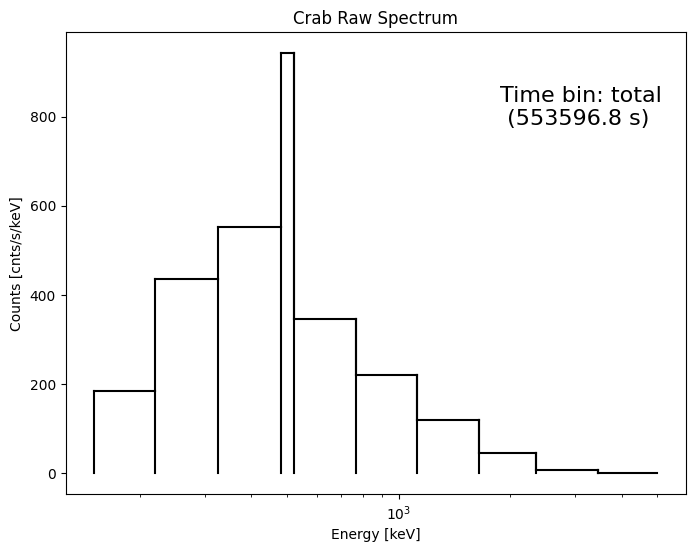

In [175]:
# Plot a raw-spectrum in counts per keV
# The narrow bin containing the 511keV positron annihilation emission is considered background for source imaging

analysis.dataset.plot_raw_spectrum()
plt.xscale('log')
plt.title("Crab Raw Spectrum")

<h3> Select which energy bin to use for the following imaging </h3>

In [176]:
# ebin 2 is recommended because it has the highest effective area and flux
# ebin:             0    |      1    |    2    |    3    |    4     |     5    |     6     |     7     |     8    |     9    |
# energies(keV): 150-220 | 220 - 325 | 325-480 | 480-520 | 520-765 | 765-1120 | 1120-1650 | 1650-2350 | 2350-3450| 3450-5000 |

#ebin, DeltaE = 0, 220 - 150
#ebin, DeltaE = 1, 325 - 220
ebin, DeltaE = 2, 480 - 325
#ebin, DeltaE = 4, 765 - 520
#ebin, DeltaE = 5, 1120 - 765

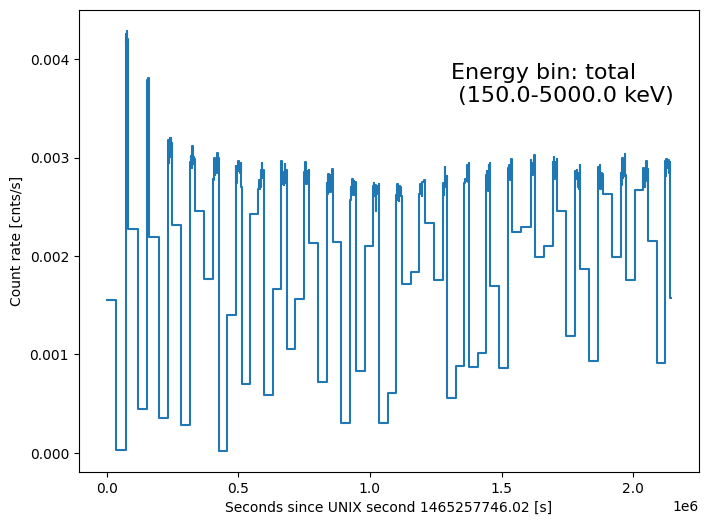

In [177]:
# Plot an unbinned (x axis is seconds) light curve of all observed data
# Notice the variability of the lightcurve for this data set.

analysis.dataset.plot_lightcurve()

Below is an image of the instrument's altitude throughout the 2016 balloon flight:
![COSI 2016 altitude plot is here](COSI_2016_altitude.png)
Later during the flight, the altitude became highly variable. This was also when observations of the Crab were optimal as the source was high in elevation. This data set excludes data that was taken when the instrument altitude dropped below 33km in an effort to minimize atmospheric background.

In [178]:
# Definition of poitings / pointing object (balloon location + Earth rotation)
pointing = Pointing(dataset=analysis.dataset,)

In [179]:
# Crab galactic coordinates (long, lat)
l1,b1 = 184.55746, -5.78436

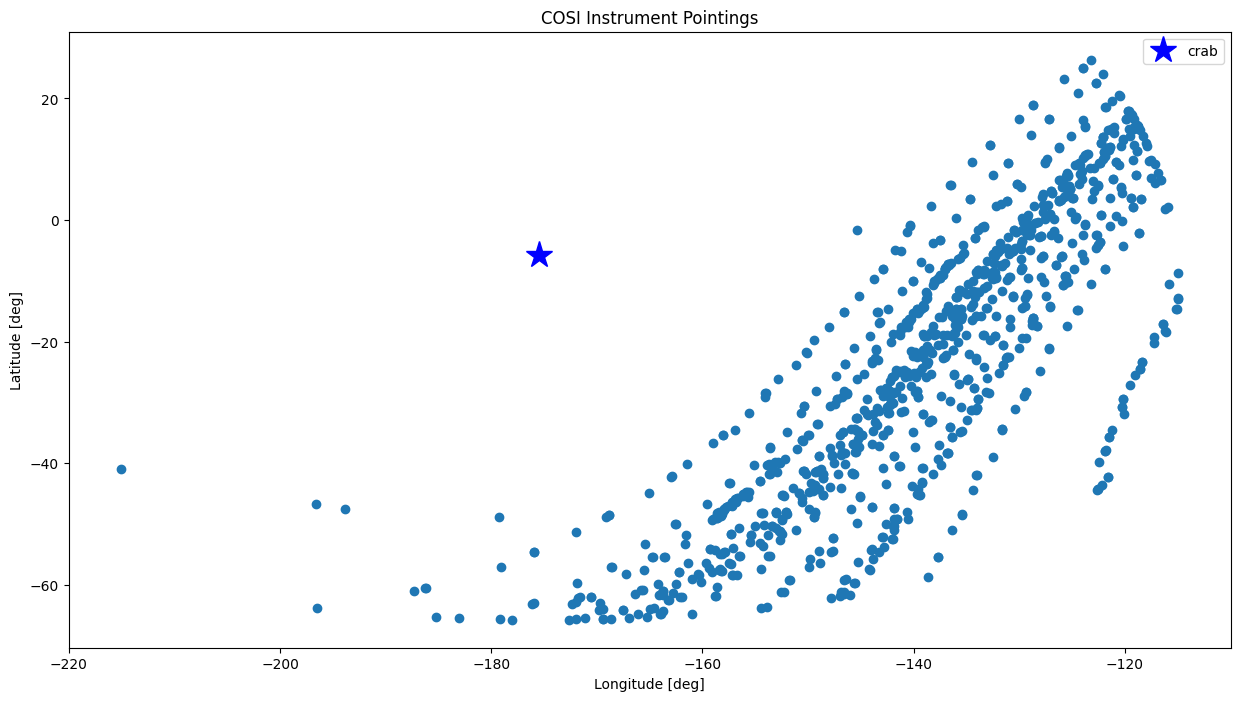

In [180]:
# Plot the position of the Crab during flight, relative to the zenith of the detector
plt.figure(figsize=(15,8))
l_exp = pointing.zpoins[:,0]
b_exp = pointing.zpoins[:,1]
l_exp[l_exp > 0] -= 360
plt.plot(l_exp,b_exp,'o')
plt.plot(l1-360,b1,'*b',markersize=20, label='crab')
plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.title('COSI Instrument Pointings')
plt.legend()

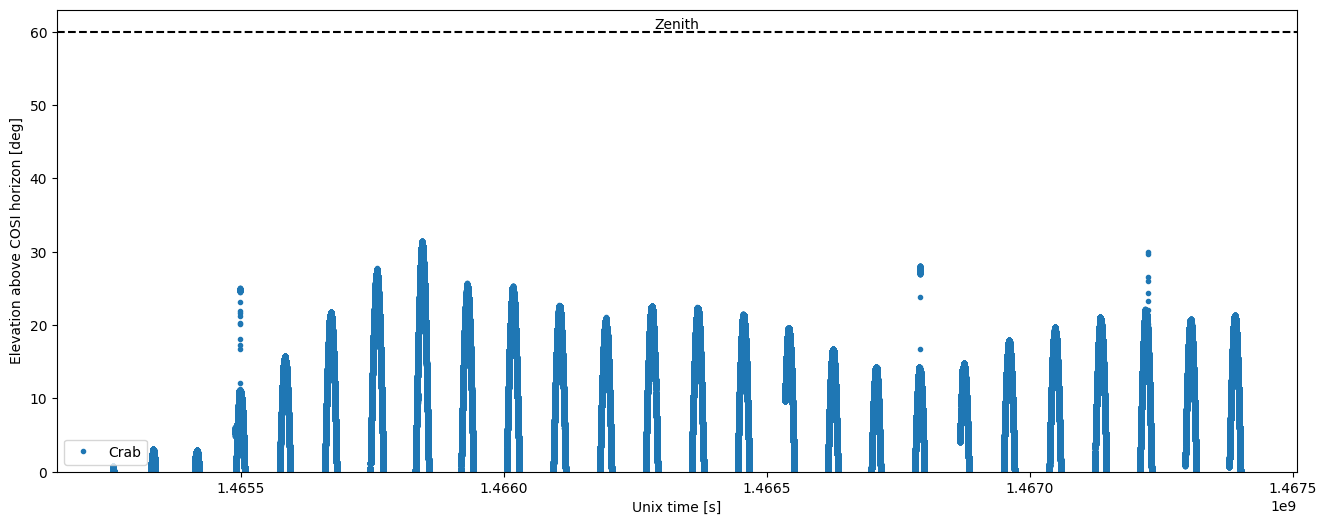

In [181]:
# Plot elevation angle of Crab relative to instrument zenith
analysis.plot_elevation([l1],[b1],['Crab'])

Due to the fact that flight data background is highly variable, we use a background tracer to better track the changes for improved background modeling

In [182]:
# Define background tracer
tracer = np.sum(analysis.dataset.binned_data,axis=(1,2,3))
tracer = tracer/np.mean(tracer)

For the background model we can select from models derived from different simulations of the 2016 flight, or a model derived from balloon data. The 'default 6deg' model is derived from the 2016 balloon data. This means we're using the flight data to define a background response.

In [183]:
# background object defined with background tracer (making the zeros zero)
background = BG(dataset=analysis.dataset,mode='default 6deg',tracer=tracer)

Reading in flight-average background response for 6 deg CDS binning ...


<h3>Reading in the continuum detector response for the full 2016 flight:</h3>

In [184]:
# Creating an object for the response
# NOTE FOR DEVELOPERS: YOU WILL NEED TO LINK TO A LOCAL RESPONSE, HERE
# THE RESPONSE FILE WAS TOO LARGE FOR GITHUB
rsp = response.SkyResponse(filename='/media/COSI10TB/2016_analysis/COSIpy/response/UpdatedRegularResponseGrid_Continuum_3bins_v1_April_2022.npz', pixel_size=6)

Reading complete continuum response. This might take a while...
Done.

Creating general RMF matrices, stay tuned...


Loop over phi bins::   0%|          | 0/30 [00:00<?, ?it/s]

Done.

Creating general IRF. Wait for it...
Done.

Deleting full matrix.
Done. Now have fun.


In [185]:
# Print response dimensions
print('response dimensions (lat, lon, phi, psi/chi, energy bins):', rsp.rsp.response_grid_normed_efinal.shape)

response dimensions (lat, lon, phi, psi/chi, energy bins): (30, 60, 30, 1145, 10)


What follows are some hard-coded sections where we define the sky and background:

<h3>Defining the sky in pixels to make images:</h3>

In [186]:
# Defining our sky-grid on a regular 6x6 pixel grid
binsize = 6.
# Set l and b pixel edges
l_arrg = np.linspace(-180,180,int(360/binsize)+1)
b_arrg = np.linspace(-90,90,int(180/binsize)+1)
# Set number of pixels in l and b
n_l = int(360/binsize)
n_b = int(180/binsize)
# Creating a grid
L_ARRg, B_ARRg = np.meshgrid(l_arrg,b_arrg)
# Choosing the center points as representative
l_arr = l_arrg[0:-1]+binsize/2
b_arr = b_arrg[0:-1]+binsize/2
L_ARR, B_ARR = np.meshgrid(l_arr,b_arr)

# Define solid angle for each pixel for normalisations later
deg2rad = np.pi/180.
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))

<h3>Convert sky grid to zenith/azimuth pairs for all pointings:</h3>

In [187]:
# Calculate the zeniths and azimuths on the defined grid for all times
zensgrid,azisgrid = zenaziGrid(pointing.ypoins[:,0],pointing.ypoins[:,1],
                               pointing.xpoins[:,0],pointing.xpoins[:,1],
                               pointing.zpoins[:,0],pointing.zpoins[:,1],
                               L_ARR.ravel(),B_ARR.ravel())
# Reshape for the following routines 
zensgrid = zensgrid.reshape(n_b,n_l,len(pointing.xpoins))
azisgrid = azisgrid.reshape(n_b,n_l,len(pointing.xpoins))

<h3>Getting the observation indices where we actually have measured photons (important for later):</h3>

In [188]:
#Determine the int value of pixel indexes that have non-zero values
nonzero_idx = background.calc_this[ebin]
nonzero_idx_num = nonzero_idx.shape[0]

<h3>Below is a function created to obtain the response of an image for any arbitrary time binning:</h3>

In [189]:
def get_image_response_from_pixelhit_general(Response,
                                             zenith,
                                             azimuth,
                                             dt,
                                             n_hours,
                                             binsize=6,
                                             cut=90,
                                             ltitude_correction=False,
                                             al=None):
    """
    Get Compton response from hit pixel for each zenith/azimuth vector input.
    Binsize determines regular sky coordinate grid in degrees.

    :param: zenith        Zenith positions of all points of predefined sky grid with
                          respect to the instrument (in deg)
    :param: azimuth       Azimuth positions of all points of predefined sky grid with
                          respect to the instrument (in deg)
    :option: binsize      Default 5 deg (matching the sky dimension of the response). If set
                          differently, make sure it matches the sky dimension as otherwise,
                          false results may be returned
    :option: cut          Threshold to cut the response calculation after a certain zenith angle.
                          Default 60
    :param: n_hours       Number of hours in cdxervation
    :option: altitude_correction Default False: use interpolated transmission probability, normalised to 33 km and 500 keV,
                          to modify number of expected photons as a function of altitude and zenith angle of cdxervation
    :option: al           Altitude values according to dt from construct_pointings(); used of altitude_correction is set to True
    """

    # Azimuthal angle is periodic in the range [0,360]
    # Zenith angle ranges from [0,180]

    # Check which pixel (index) was hit on regular grid
    hit_pixel_zi = np.floor(zenith/binsize)
    hit_pixel_ai = np.floor(azimuth/binsize)

    # Check which pixel centre
    hit_pixel_z = (hit_pixel_zi+0.5)*binsize
    hit_pixel_a = (hit_pixel_ai+0.5)*binsize

    # Check which zeniths are beyond threshold
    bad_idx = np.where(hit_pixel_z > cut)

    # Choose pixels with hits to write to output array
    za_idx = np.array([hit_pixel_zi,hit_pixel_ai]).astype(int)

    nz = zenith.shape[2]

    n_lon = int(360/binsize)
    n_lat = int(180/binsize)
    
    l_arrg = np.linspace(-180,180,int(360/binsize)+1)
    b_arrg = np.linspace(-90,90,int(180/binsize)+1)
    L_ARRg, B_ARRg = np.meshgrid(l_arrg,b_arrg)
    l_arr = l_arrg[0:-1]+binsize/2
    b_arr = b_arrg[0:-1]+binsize/2
    L_ARR, B_ARR = np.meshgrid(l_arr,b_arr)

    # Take care of regular grid by applying weighting with latitude
    weights = ((binsize*np.pi/180)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))).repeat(nz).reshape(n_lat,n_lon,nz)
    weights[bad_idx] = 0

    
    # Check for negative weights and indices and remove them
    weights[za_idx[0,:] < 0] = 0.
    weights[za_idx[1,:] < 0] = 0.
    za_idx[0,za_idx[0,:] < 0] = 0.
    za_idx[1,za_idx[1,:] < 0] = 0.
    
    
    if altitude_correction == True:
        altitude_response = return_altitude_response()
    else:
        altitude_response = one_func

    # Get responses for each pixel    
    image_response = np.zeros((n_hours,n_lat,n_lon,Response.shape[2]))

    for c in tqdm(range(n_hours)):
        cdx = np.where((pointing.cdtpoins > analysis.dataset.times.times_min[analysis.dataset.times.n_ph_dx[c]]) &
                       (pointing.cdtpoins <= analysis.dataset.times.times_max[analysis.dataset.times.n_ph_dx[c]]))[0]
        
        # This calculation is a look-up of the response entries. 
        image_response[c,:,:,:] += np.sum(Response[za_idx[0,:,:,cdx],za_idx[1,:,:,cdx],:]*np.einsum('klij->iklj', weights[:,:,cdx,None])*dt[cdx,None,None,None],axis=0)

    return image_response

<h3>Translating the sponse in the Compton Data Space coordinates to the sky</h3>

In [190]:
sky_response_CDS = rsp.rsp.response_grid_normed_efinal.reshape(
    n_b,
    n_l,
    analysis.dataset.phis.n_phi_bins*\
    analysis.dataset.fisbels.n_fisbel_bins,
    10)[:,:,nonzero_idx,ebin]

In [191]:
# reduced response dimensions:
# lat x lon x CDS
sky_response_CDS.shape

(30, 60, 2525)

<h3>Calculation of the general response for the current data set</h3>

In [270]:
sky_response_scaled = get_image_response_from_pixelhit_general(
    Response=sky_response_CDS,
    zenith=zensgrid,
    azimuth=azisgrid,
    dt=pointing.dtpoins,
    n_hours=analysis.dataset.times.n_ph,
    binsize=6.,
    #cut=90.,
    altitude_correction=False,
    al=np.ones(len(pointing.dtpoins)))

  0%|          | 0/308 [00:00<?, ?it/s]

In [271]:
# data-set-specific response dimensions
# times x lat x lon x CDS

print('The data specific sky response dimensions:',sky_response_scaled.shape)
sky_response_scaled_time = sky_response_scaled.shape[0]

The data specific sky response dimensions: (308, 30, 60, 2525)


<h3>Calculation of the 'exposure map' - the response weighted by time:</h3>

In [272]:
expo_map_crab = np.zeros((n_b,n_l))
for i in tqdm(range(sky_response_scaled_time)):
    expo_map_crab += np.sum(sky_response_scaled[i,:,:,:],axis=2)

  0%|          | 0/308 [00:00<?, ?it/s]

<h3> Choosing region of bad exposure - not seen by the instrument during the selected observation time:</h3>

In [273]:
bad_expo = np.where(expo_map_crab/domega <= 100)

<h3>Plotting the exposure map weighted with the pixel size:</h3>

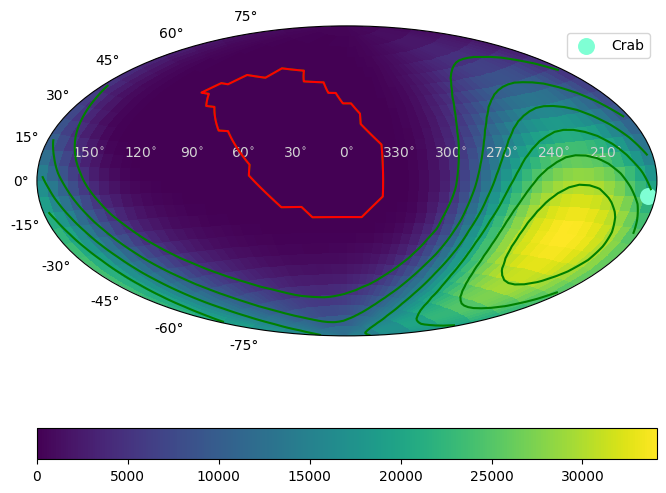

In [274]:
plt.figure(figsize=(8,8))
plt.style.use('default')
plt.subplot(projection='aitoff')
plt.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,np.flip(expo_map_crab/domega,axis=1))
plt.colorbar(orientation='horizontal')
cont1 = plt.contour(L_ARR*deg2rad,B_ARR*deg2rad,np.flip(expo_map_crab/domega,axis=1),colors='green')
cont2 = plt.contour(L_ARR*deg2rad,B_ARR*deg2rad, np.flip(expo_map_crab/domega,axis=1), levels =[0],colors='r')
plt.xticks(np.array([-150,-120,-90,-60,-30,0,30,60,90,120,150])*deg2rad,labels=[r'$150^{\circ}$'+'\n',
                                                         r'$120^{\circ}$'+'\n',
                                                         r'$90^{\circ}$'+'\n',
                                                         r'$60^{\circ}$'+'\n',
                                                         r'$30^{\circ}$'+'\n',                       
                                                         r'$0^{\circ}$'+'\n',
                                                         r'$330^{\circ}$'+'\n',
                                                         r'$300^{\circ}$'+'\n',                       
                                                         r'$270^{\circ}$'+'\n',
                                                         r'$240^{\circ}$'+'\n',                                                    
                                                         r'$210^{\circ}$'+'\n'],color='lightgray')

plt.scatter(np.deg2rad(360-l1),np.deg2rad(b1),color='aquamarine',marker='.',s=500, label= 'Crab')
plt.legend()
plt.show()


<h1>Begin Richardson-Lucy Deconvolution:</h1>

<h3>Define function for a starting map fo the RL deconvolution - an isotropic map:</h3>

In [275]:
def IsoMap(ll,bb,A0,binsize=6):
    shape = np.ones(ll.shape)
    norm = np.sum(shape*(binsize*np.pi/180)*(np.sin(np.deg2rad(bb+binsize/2)) - np.sin(np.deg2rad(bb-binsize/2))))
    val = A0*shape/norm
    return val

<h3> Define suitable background time nodes:</h3>
We select background time nodes generated from a Baysian Blocks analysis to determine optimal sections of data where each background section if fit independently.
For this imaging demonstration, we provide the optimal time nodes for this data set.

In [276]:
# Selected background time notes [time bin]
all_edges = np.array([  0 ,   6,  12,  23, 35, 48,  63,  79,  93,
                       107, 121, 134, 149, 163, 176, 187, 199, 209,
                       221, 231, 243, 255, 269, 281, 293, 308])
all_edges_num = all_edges.shape[0]

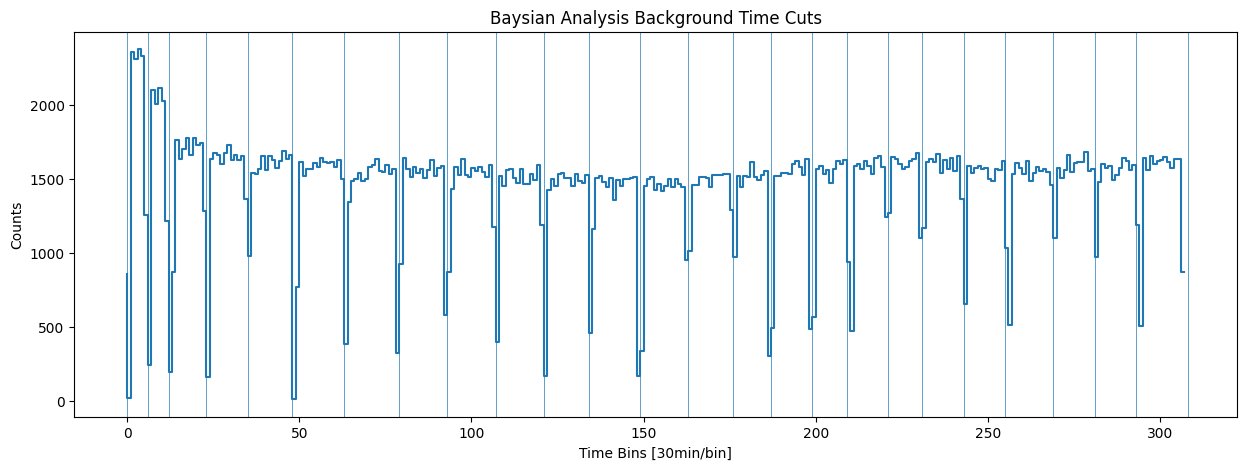

In [277]:
plt.figure(figsize=(15,5))
plt.step(np.arange(len(np.sum(analysis.dataset.binned_data,axis=(1,2,3)))),np.sum(analysis.dataset.binned_data,axis=(1,2,3)))
for e in all_edges:
    plt.axvline(e,linestyle='-', linewidth=0.5)
    plt.title("Baysian Analysis Background Time Cuts")
    plt.xlabel("Time Bins [30min/bin]")
    plt.ylabel("Counts")

<h3>Add these time nodes to the current background model:</h3>

In [278]:
background.make_bg_cuts(list(all_edges+1))

<h3>Select only the previously defined energy bin for data set:</h3>

In [279]:
crab_dataset = analysis.dataset.binned_data[:,ebin,:,:].reshape(sky_response_scaled_time,30*1145)[:,nonzero_idx]

<h3>Select this energy bin for the background model and setting the cut values, indices, and total number of background cuts applied:</h3>

In [280]:
background_model = background.bg_model_reduced[ebin]

In [281]:
bg_cuts, idx_arr, Ncuts = background.bg_cuts, background.idx_arr, background.Ncuts

<h3>Loading Stan model fits for the given data set</h3>

In [282]:
try:
    model_multimap = pickle.load(open('crab_2016_stanfit.pkl', 'rb'))
except:
    print('Model not yet compiled')
    model_multimap = pystan.StanModel('fit_COSI_conved_2D_multimap_indivBG.stan')
    with open('./crab_2016_stanfit.pkl', 'wb') as f:
        pickle.dump(model_multimap, f)
#model_multimap = pickle.load(open('crab_2016_stanfit.pkl', 'rb'))

<h3> Set the initial background fits in the Richardson-Lucy algorithm to 1 for the first iteration, then to random values between 0.83 and 9.3 for the following iteration</h3>

In [283]:
fitted_bg_it1 = np.full(np.shape(all_edges), 1.0)
fitted_bg = 0.85+np.random.rand(all_edges_num)*0.1

<h1>Richardson-Lucy algorithm (individual step explaination included in code):</h1>

Convolving with response (init expectation), iteration 0


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Calculating Delta image, iteration 1, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

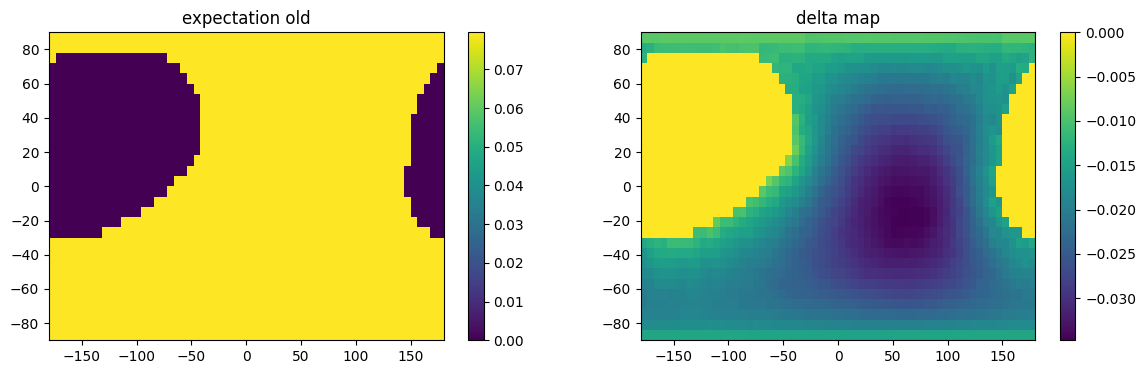

Convolving Delta image, iteration 1


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 1
Maximum acceleration parameter found:  2.29
Fitting delta-map in addition to old map, iteration 1
Proceeding without acceleration parameter.
Calculating Delta image, iteration 2, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

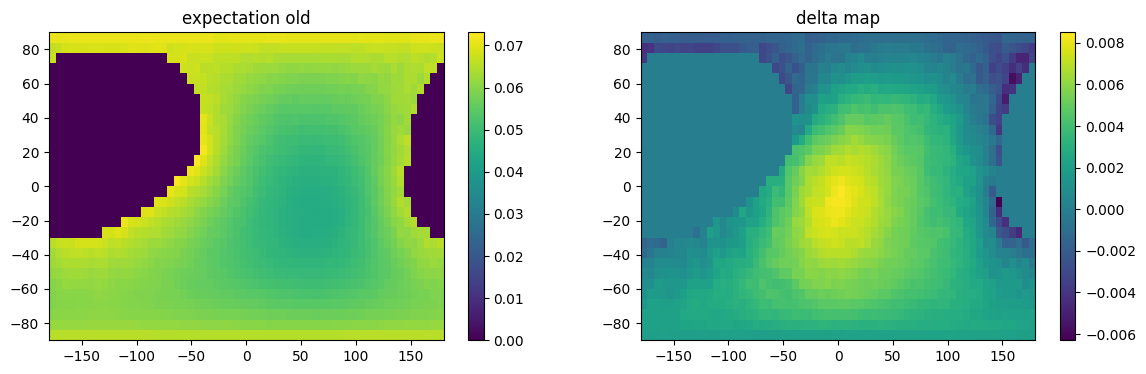

Convolving Delta image, iteration 2


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 2
Maximum acceleration parameter found:  9.999
Fitting delta-map in addition to old map, iteration 2
Proceeding without acceleration parameter.
Calculating Delta image, iteration 3, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

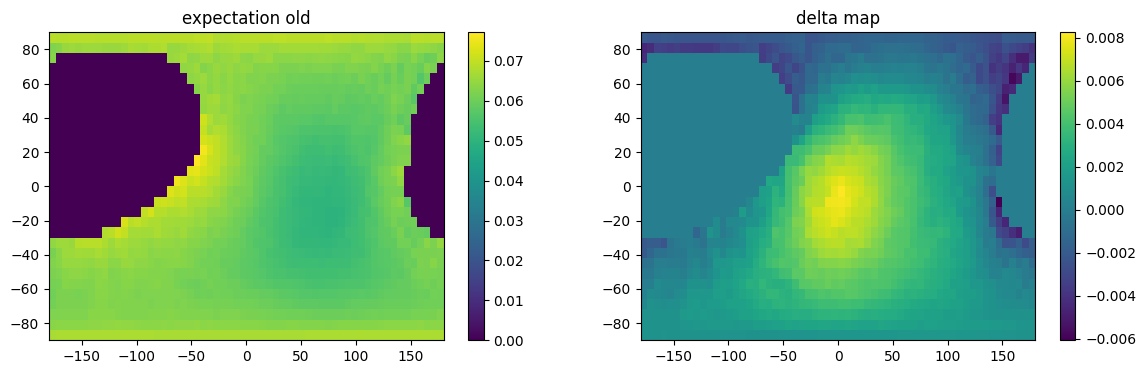

Convolving Delta image, iteration 3


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 3
Maximum acceleration parameter found:  9.365
Fitting delta-map in addition to old map, iteration 3
Proceeding without acceleration parameter.
Calculating Delta image, iteration 4, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

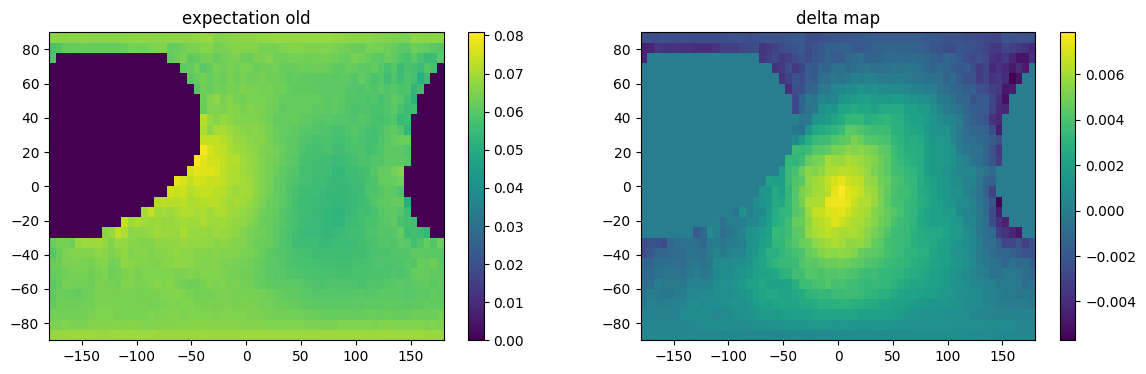

Convolving Delta image, iteration 4


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 4
Maximum acceleration parameter found:  8.898
Fitting delta-map in addition to old map, iteration 4
Proceeding without acceleration parameter.
Calculating Delta image, iteration 5, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

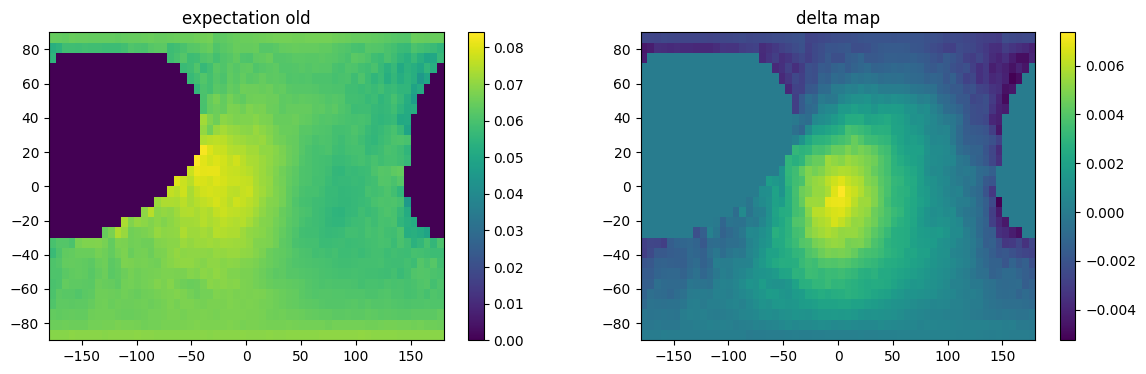

Convolving Delta image, iteration 5


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 5
Maximum acceleration parameter found:  8.574
Fitting delta-map in addition to old map, iteration 5
Proceeding without acceleration parameter.
Calculating Delta image, iteration 6, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

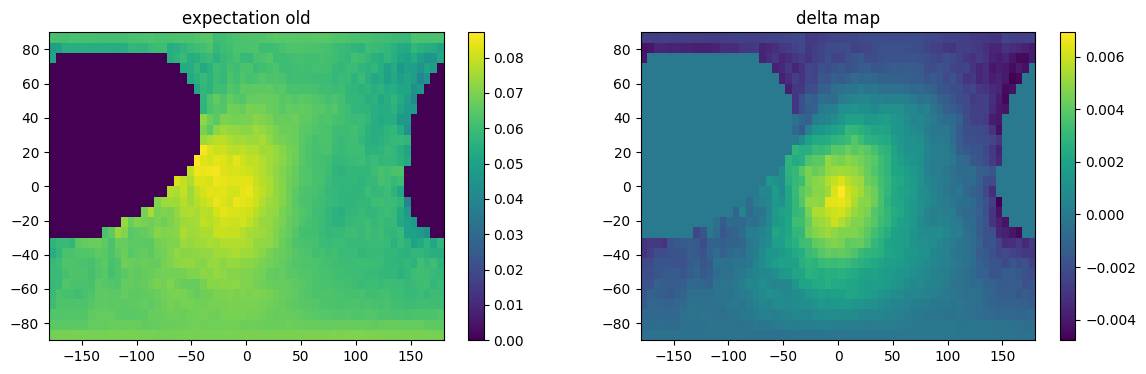

Convolving Delta image, iteration 6


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 6
Maximum acceleration parameter found:  8.351
Fitting delta-map in addition to old map, iteration 6
Proceeding without acceleration parameter.
Calculating Delta image, iteration 7, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

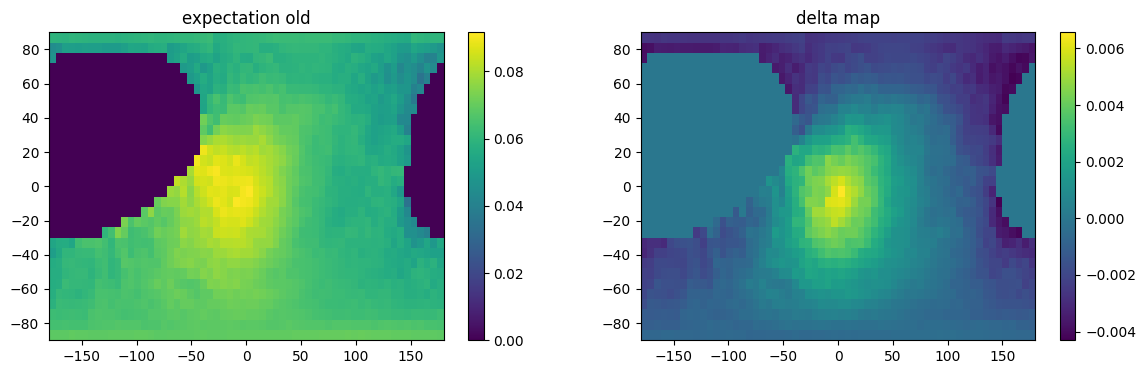

Convolving Delta image, iteration 7


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 7
Maximum acceleration parameter found:  8.173
Fitting delta-map in addition to old map, iteration 7
Proceeding without acceleration parameter.
Calculating Delta image, iteration 8, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

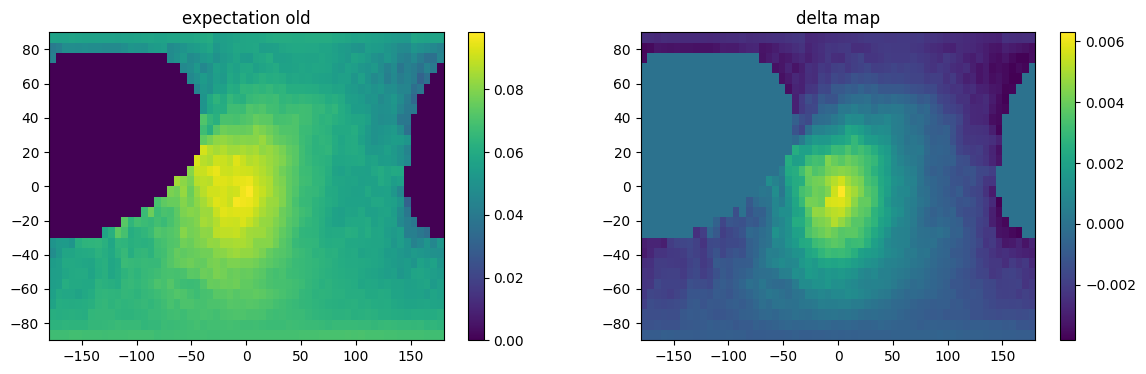

Convolving Delta image, iteration 8


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 8
Maximum acceleration parameter found:  8.065
Fitting delta-map in addition to old map, iteration 8
Proceeding without acceleration parameter.
Calculating Delta image, iteration 9, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

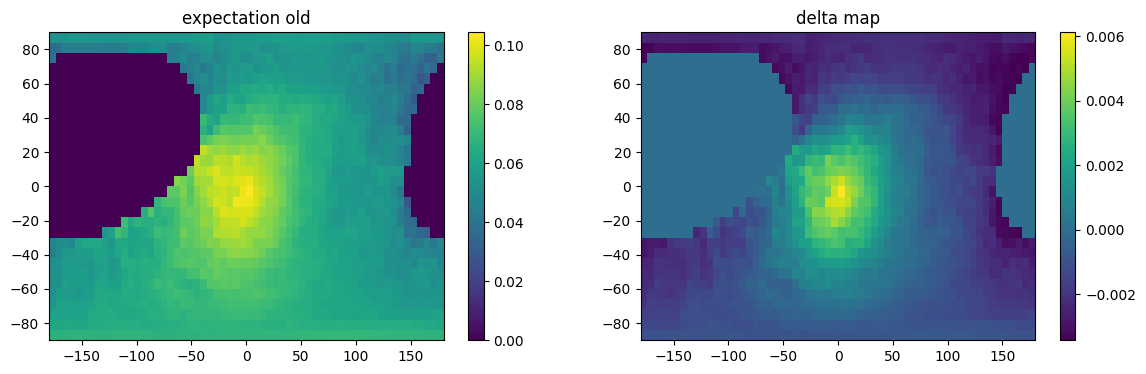

Convolving Delta image, iteration 9


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 9
Maximum acceleration parameter found:  8.006
Fitting delta-map in addition to old map, iteration 9
Proceeding without acceleration parameter.
Calculating Delta image, iteration 10, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

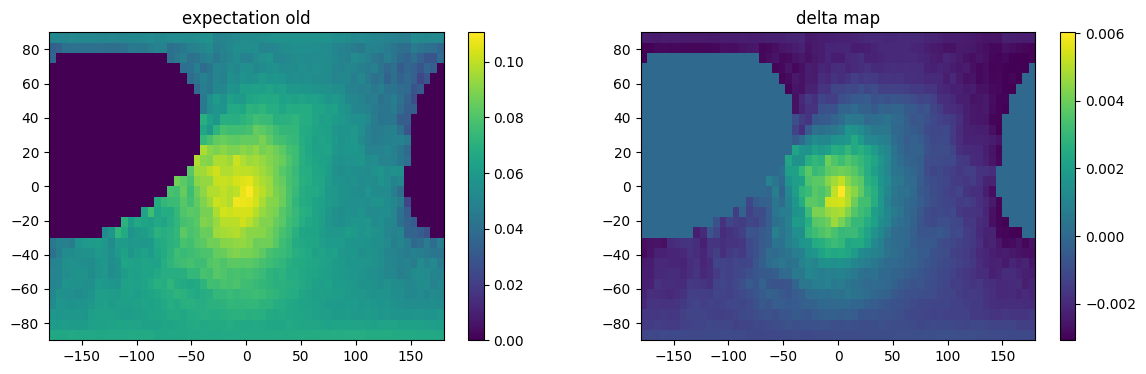

Convolving Delta image, iteration 10


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 10
Maximum acceleration parameter found:  7.978
Fitting delta-map in addition to old map, iteration 10
Proceeding without acceleration parameter.
Calculating Delta image, iteration 11, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

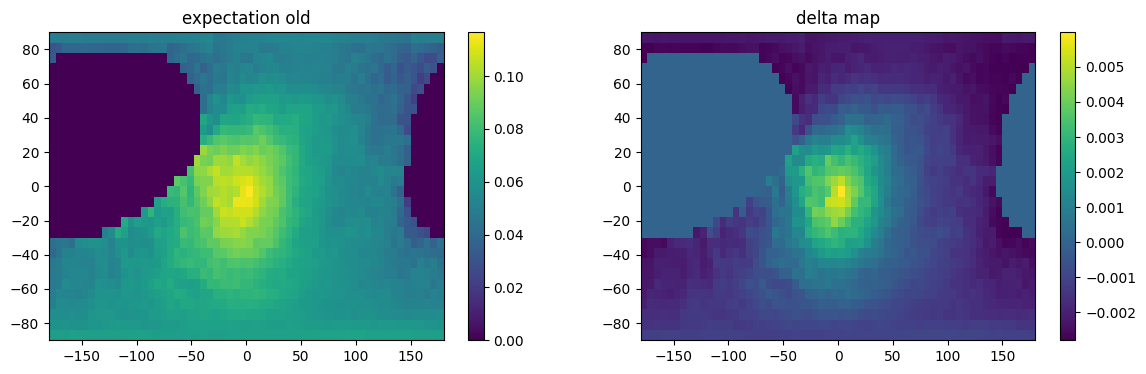

Convolving Delta image, iteration 11


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 11
Maximum acceleration parameter found:  7.972
Fitting delta-map in addition to old map, iteration 11
Proceeding without acceleration parameter.
Calculating Delta image, iteration 12, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

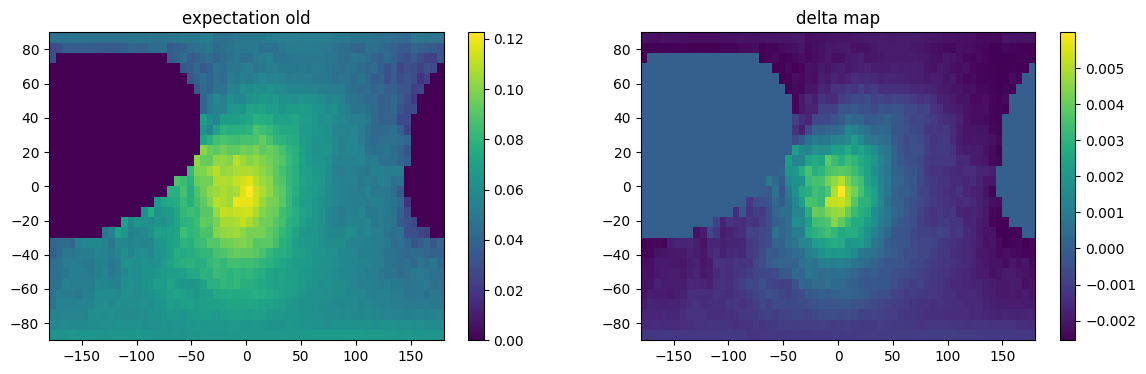

Convolving Delta image, iteration 12


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 12
Maximum acceleration parameter found:  7.98
Fitting delta-map in addition to old map, iteration 12
Proceeding without acceleration parameter.
Calculating Delta image, iteration 13, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

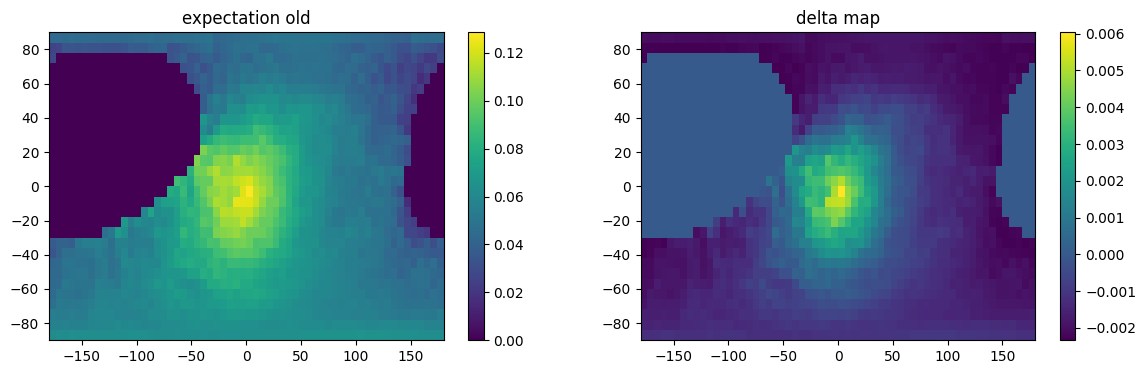

Convolving Delta image, iteration 13


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 13
Maximum acceleration parameter found:  7.997
Fitting delta-map in addition to old map, iteration 13
Proceeding without acceleration parameter.
Calculating Delta image, iteration 14, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

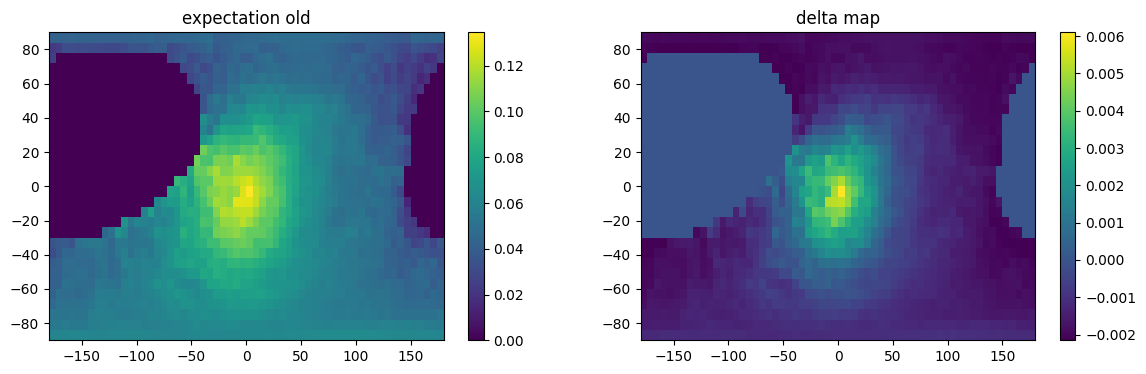

Convolving Delta image, iteration 14


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 14
Maximum acceleration parameter found:  8.019
Fitting delta-map in addition to old map, iteration 14
Proceeding without acceleration parameter.
Calculating Delta image, iteration 15, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

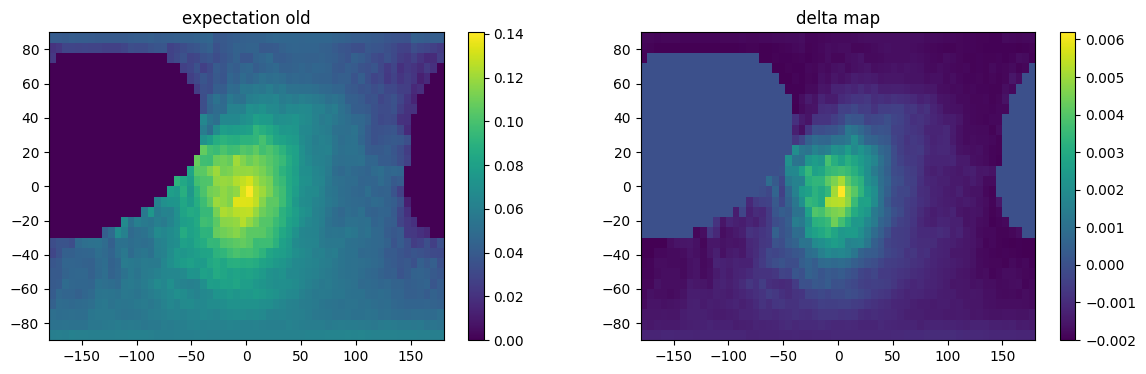

Convolving Delta image, iteration 15


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 15
Maximum acceleration parameter found:  8.046
Fitting delta-map in addition to old map, iteration 15
Proceeding without acceleration parameter.
Calculating Delta image, iteration 16, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

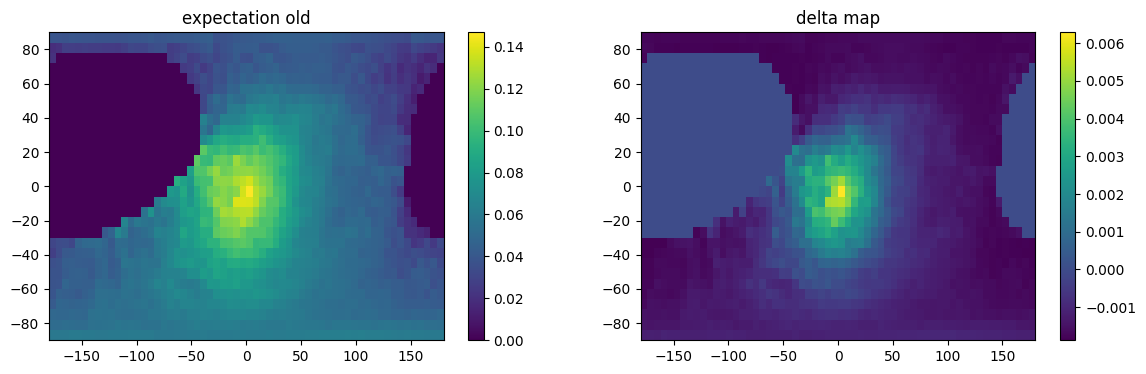

Convolving Delta image, iteration 16


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 16
Maximum acceleration parameter found:  8.074
Fitting delta-map in addition to old map, iteration 16
Proceeding without acceleration parameter.
Calculating Delta image, iteration 17, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

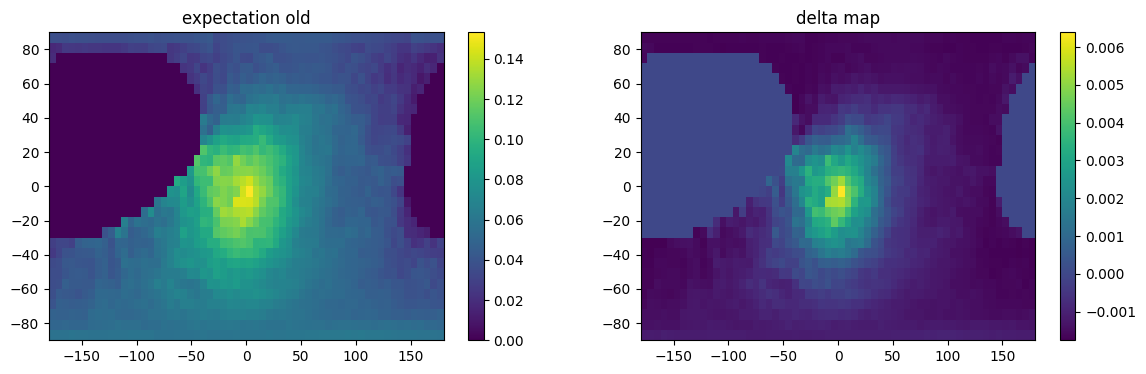

Convolving Delta image, iteration 17


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 17
Maximum acceleration parameter found:  8.102
Fitting delta-map in addition to old map, iteration 17
Proceeding without acceleration parameter.
Calculating Delta image, iteration 18, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

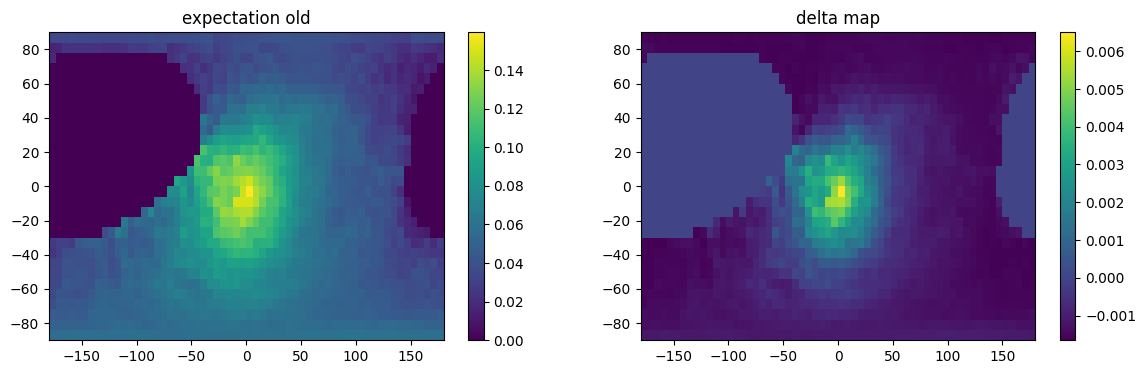

Convolving Delta image, iteration 18


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 18
Maximum acceleration parameter found:  8.124
Fitting delta-map in addition to old map, iteration 18
Proceeding without acceleration parameter.
Calculating Delta image, iteration 19, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

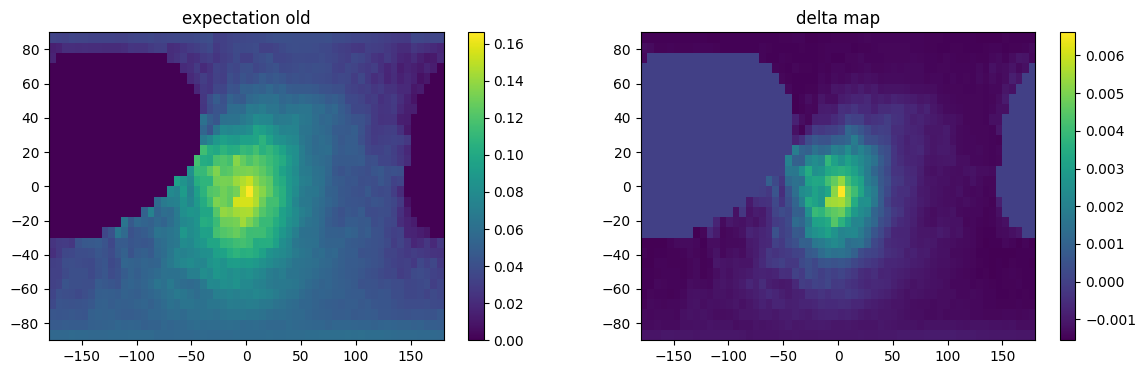

Convolving Delta image, iteration 19


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 19
Maximum acceleration parameter found:  8.146
Fitting delta-map in addition to old map, iteration 19
Proceeding without acceleration parameter.
Calculating Delta image, iteration 20, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

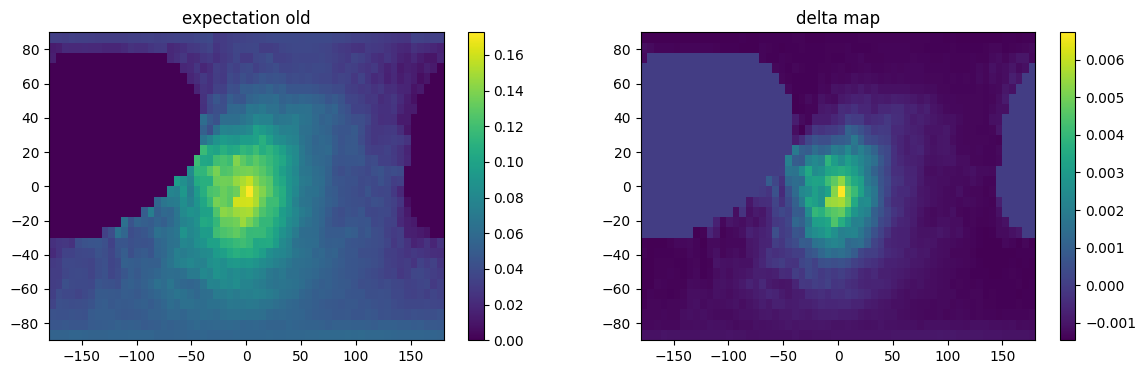

Convolving Delta image, iteration 20


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 20
Maximum acceleration parameter found:  8.168
Fitting delta-map in addition to old map, iteration 20
Proceeding without acceleration parameter.
Calculating Delta image, iteration 21, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

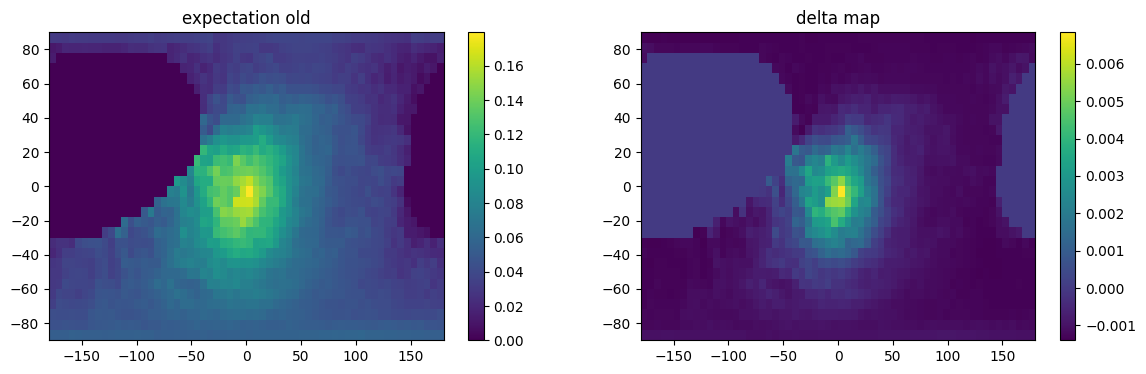

Convolving Delta image, iteration 21


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 21
Maximum acceleration parameter found:  8.191
Fitting delta-map in addition to old map, iteration 21
Proceeding without acceleration parameter.
Calculating Delta image, iteration 22, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

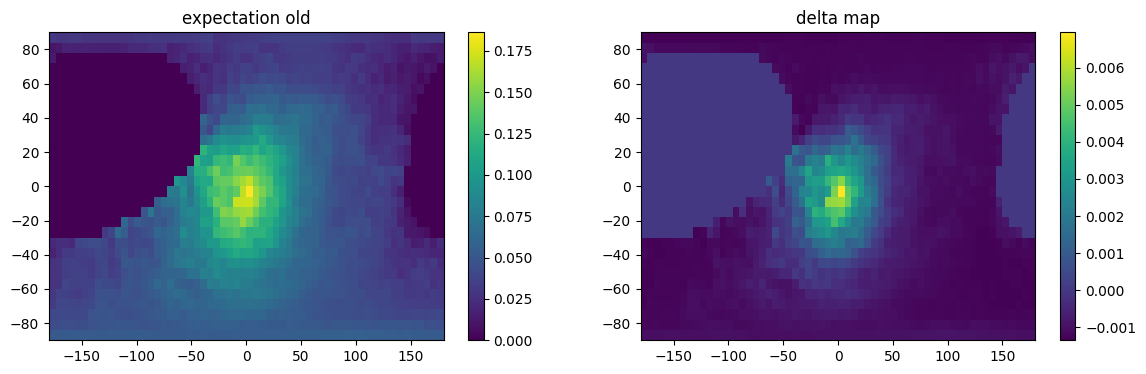

Convolving Delta image, iteration 22


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 22
Maximum acceleration parameter found:  8.214
Fitting delta-map in addition to old map, iteration 22
Proceeding without acceleration parameter.
Calculating Delta image, iteration 23, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

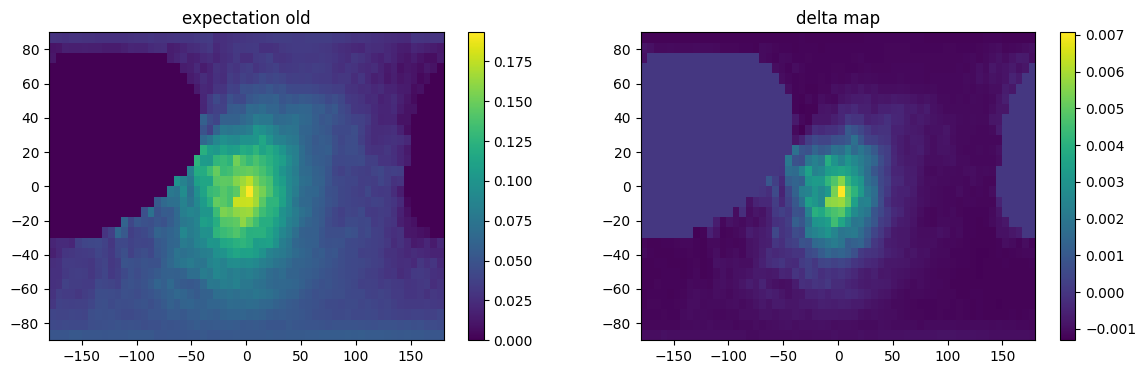

Convolving Delta image, iteration 23


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 23
Maximum acceleration parameter found:  8.237
Fitting delta-map in addition to old map, iteration 23
Proceeding without acceleration parameter.
Calculating Delta image, iteration 24, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

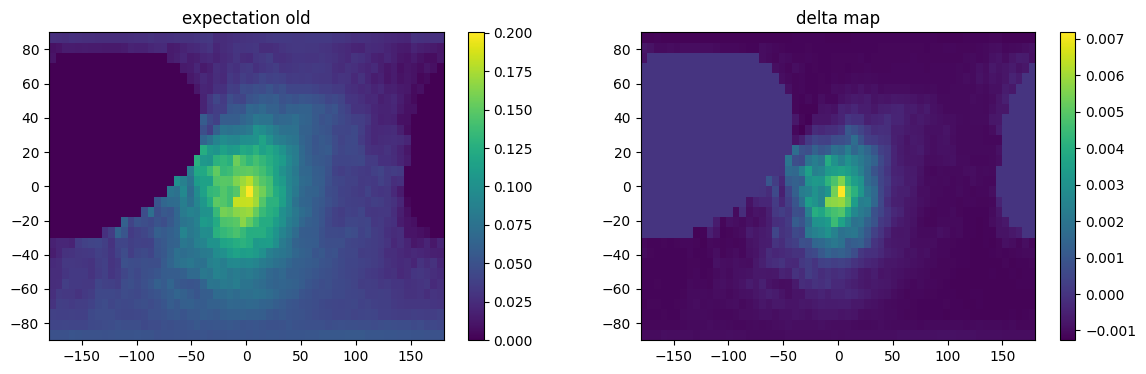

Convolving Delta image, iteration 24


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 24
Maximum acceleration parameter found:  8.26
Fitting delta-map in addition to old map, iteration 24
Proceeding without acceleration parameter.
Calculating Delta image, iteration 25, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

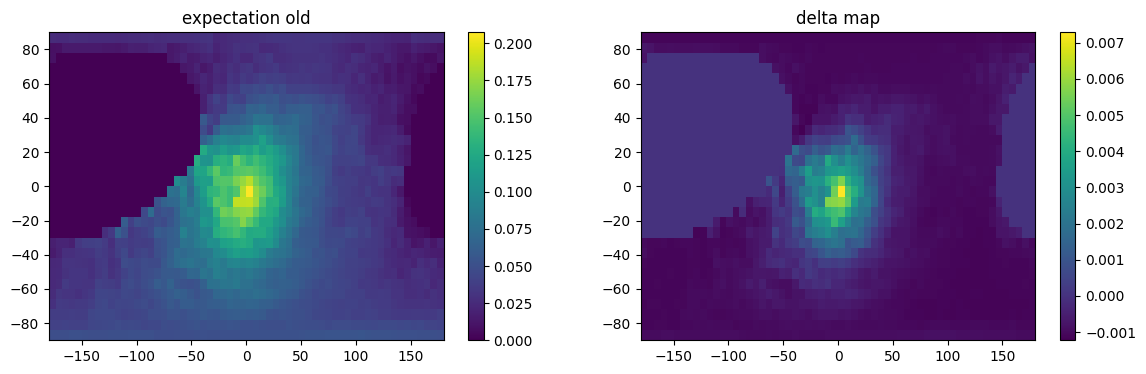

Convolving Delta image, iteration 25


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 25
Maximum acceleration parameter found:  8.283
Fitting delta-map in addition to old map, iteration 25
Proceeding without acceleration parameter.
Calculating Delta image, iteration 26, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

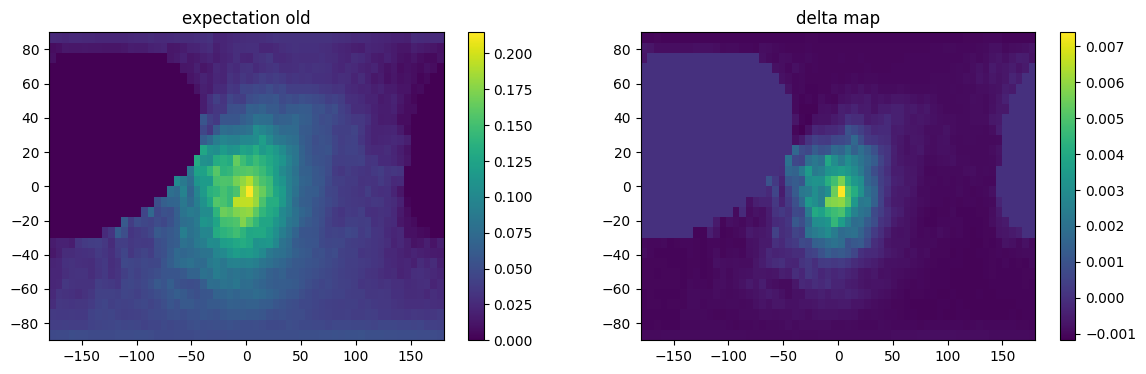

Convolving Delta image, iteration 26


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 26
Maximum acceleration parameter found:  8.306
Fitting delta-map in addition to old map, iteration 26
Proceeding without acceleration parameter.
Calculating Delta image, iteration 27, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

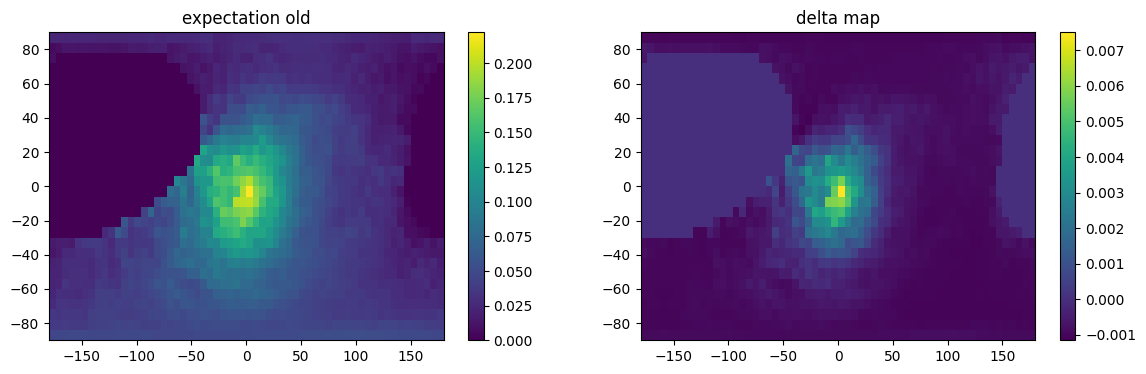

Convolving Delta image, iteration 27


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 27
Maximum acceleration parameter found:  8.328
Fitting delta-map in addition to old map, iteration 27
Proceeding without acceleration parameter.
Calculating Delta image, iteration 28, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

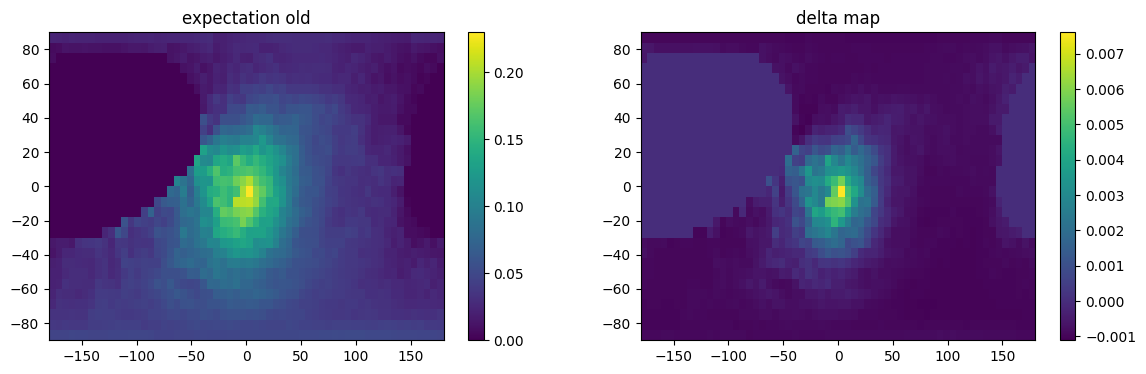

Convolving Delta image, iteration 28


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 28
Maximum acceleration parameter found:  8.351
Fitting delta-map in addition to old map, iteration 28
Proceeding without acceleration parameter.
Calculating Delta image, iteration 29, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

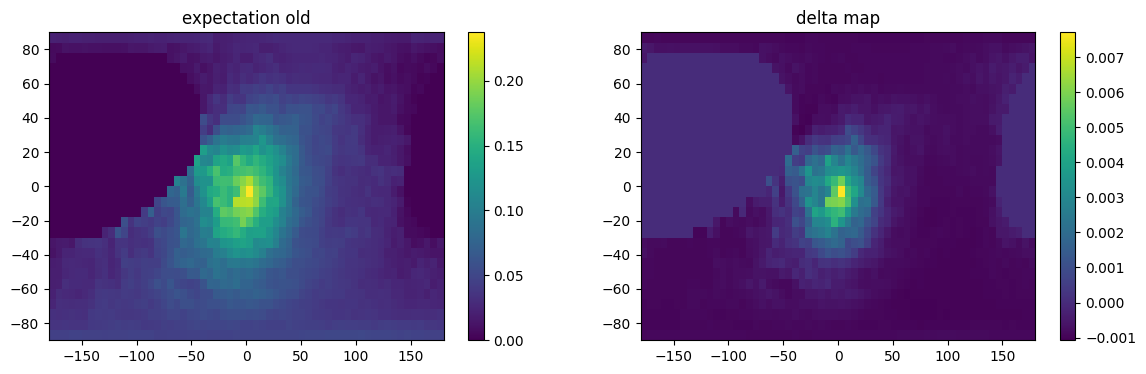

Convolving Delta image, iteration 29


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 29
Maximum acceleration parameter found:  8.374
Fitting delta-map in addition to old map, iteration 29
Proceeding without acceleration parameter.
Calculating Delta image, iteration 30, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

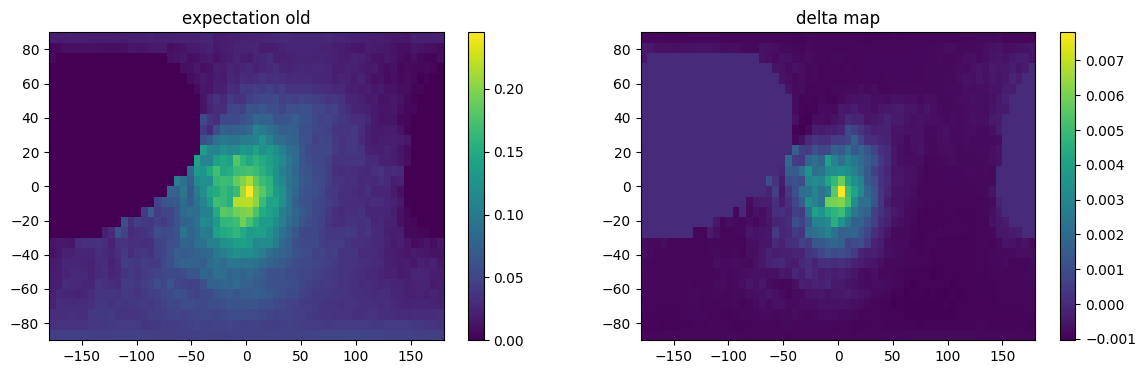

Convolving Delta image, iteration 30


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 30
Maximum acceleration parameter found:  8.396
Fitting delta-map in addition to old map, iteration 30
Proceeding without acceleration parameter.
Calculating Delta image, iteration 31, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

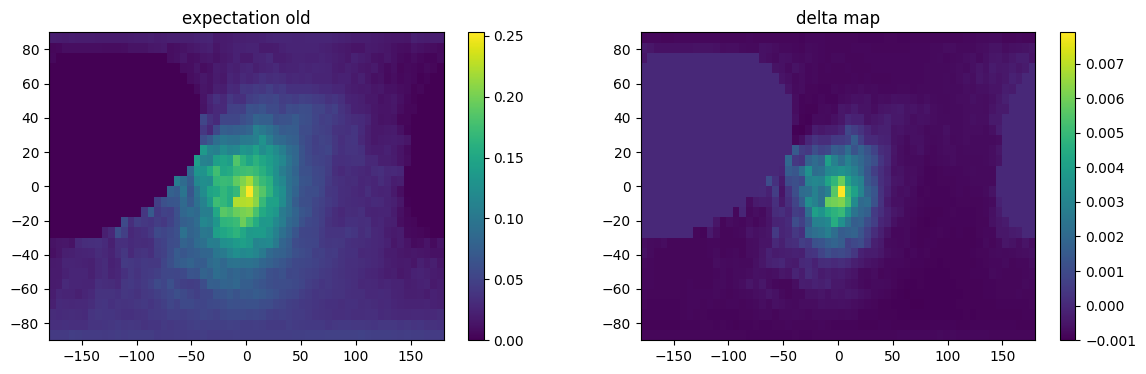

Convolving Delta image, iteration 31


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 31
Maximum acceleration parameter found:  8.419
Fitting delta-map in addition to old map, iteration 31
Proceeding without acceleration parameter.
Calculating Delta image, iteration 32, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

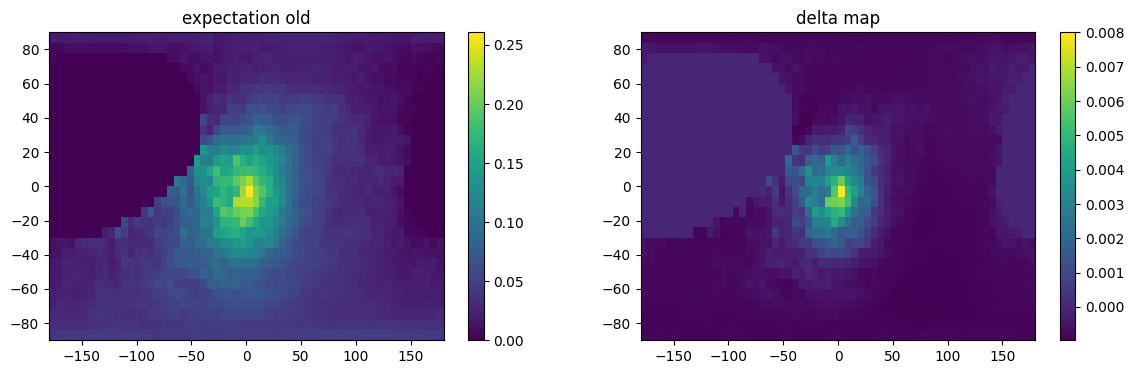

Convolving Delta image, iteration 32


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 32
Maximum acceleration parameter found:  8.441
Fitting delta-map in addition to old map, iteration 32
Proceeding without acceleration parameter.
Calculating Delta image, iteration 33, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

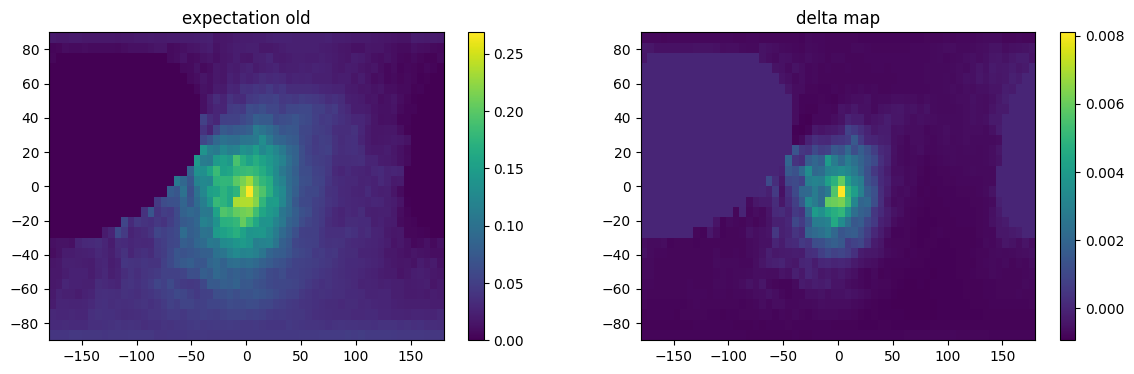

Convolving Delta image, iteration 33


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 33
Maximum acceleration parameter found:  8.463
Fitting delta-map in addition to old map, iteration 33
Proceeding without acceleration parameter.
Calculating Delta image, iteration 34, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

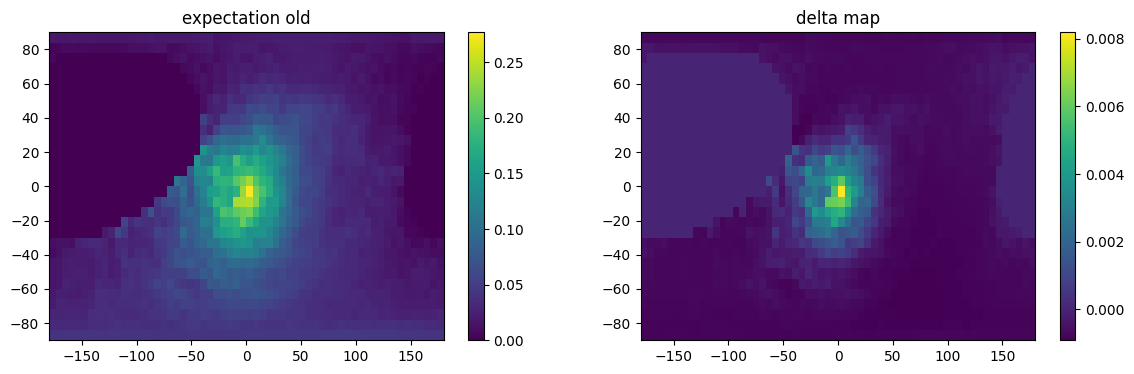

Convolving Delta image, iteration 34


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 34
Maximum acceleration parameter found:  8.485
Fitting delta-map in addition to old map, iteration 34
Proceeding without acceleration parameter.
Calculating Delta image, iteration 35, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

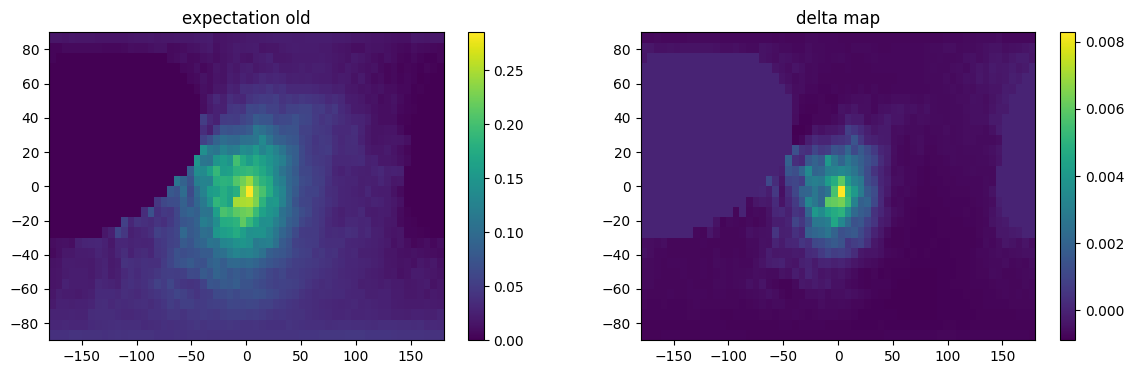

Convolving Delta image, iteration 35


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 35
Maximum acceleration parameter found:  8.507
Fitting delta-map in addition to old map, iteration 35
Proceeding without acceleration parameter.
Calculating Delta image, iteration 36, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

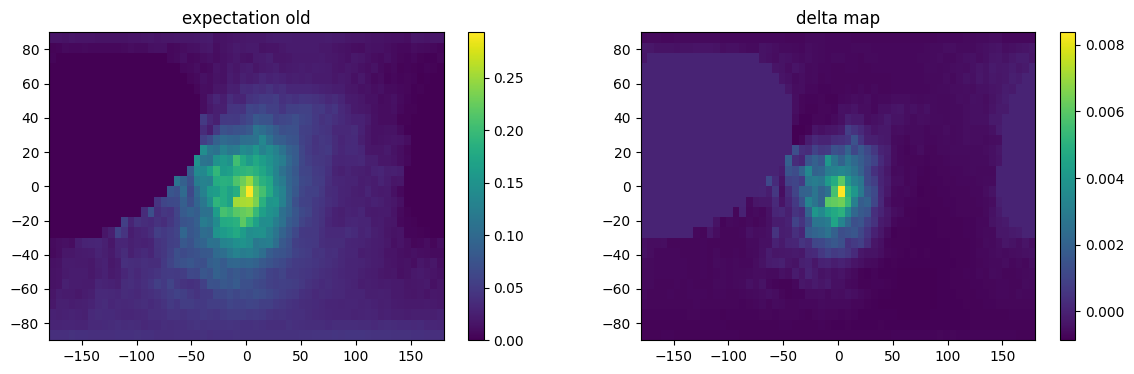

Convolving Delta image, iteration 36


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 36
Maximum acceleration parameter found:  8.529
Fitting delta-map in addition to old map, iteration 36
Proceeding without acceleration parameter.
Calculating Delta image, iteration 37, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

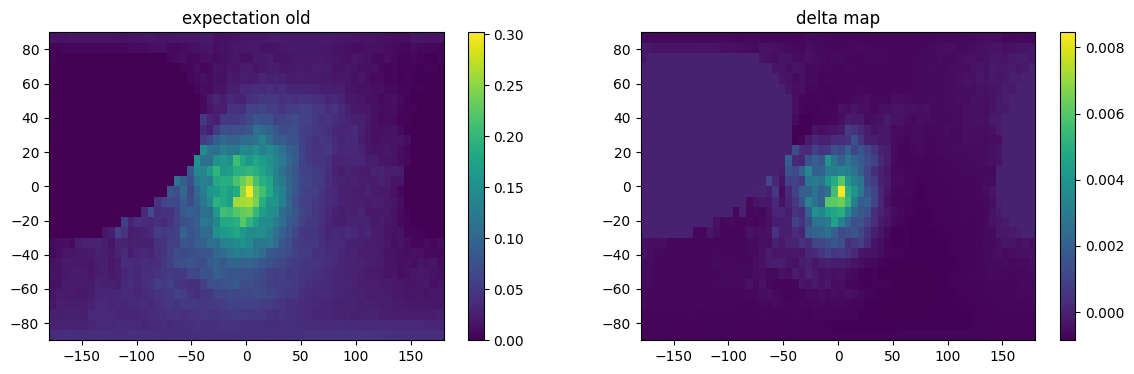

Convolving Delta image, iteration 37


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 37
Maximum acceleration parameter found:  8.55
Fitting delta-map in addition to old map, iteration 37
Proceeding without acceleration parameter.
Calculating Delta image, iteration 38, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

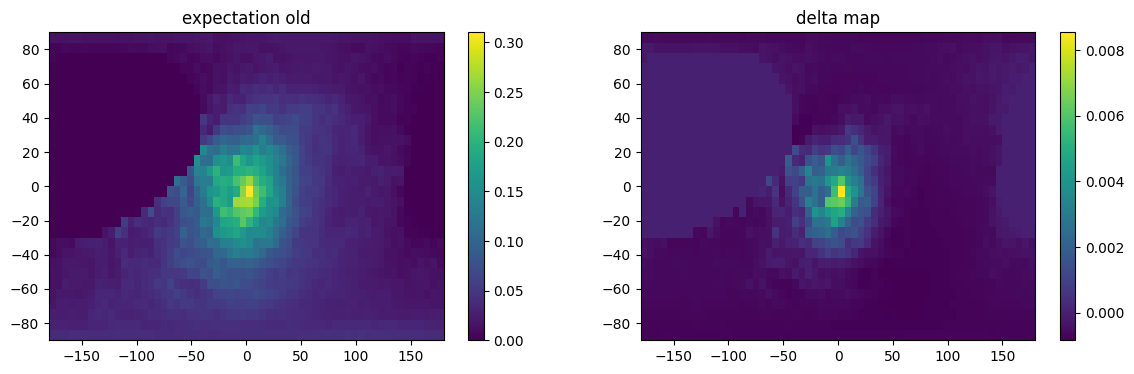

Convolving Delta image, iteration 38


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 38
Maximum acceleration parameter found:  8.572
Fitting delta-map in addition to old map, iteration 38
Proceeding without acceleration parameter.
Calculating Delta image, iteration 39, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

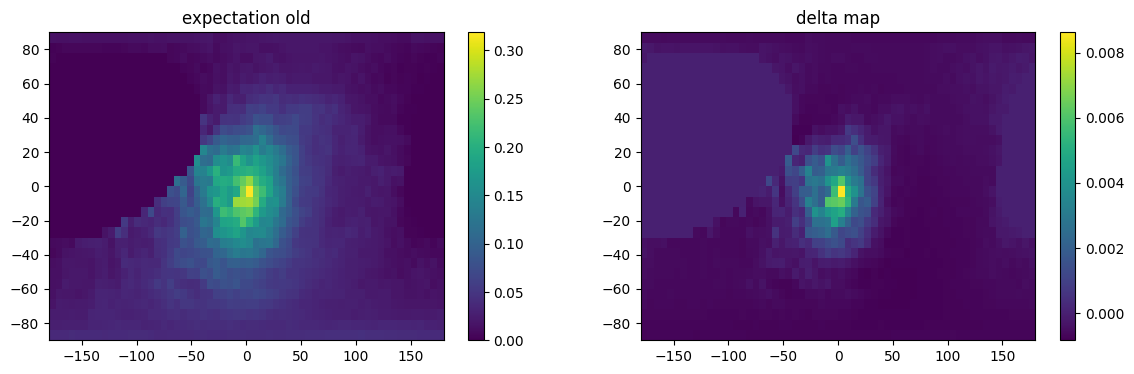

Convolving Delta image, iteration 39


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 39
Maximum acceleration parameter found:  8.593
Fitting delta-map in addition to old map, iteration 39
Proceeding without acceleration parameter.
Calculating Delta image, iteration 40, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

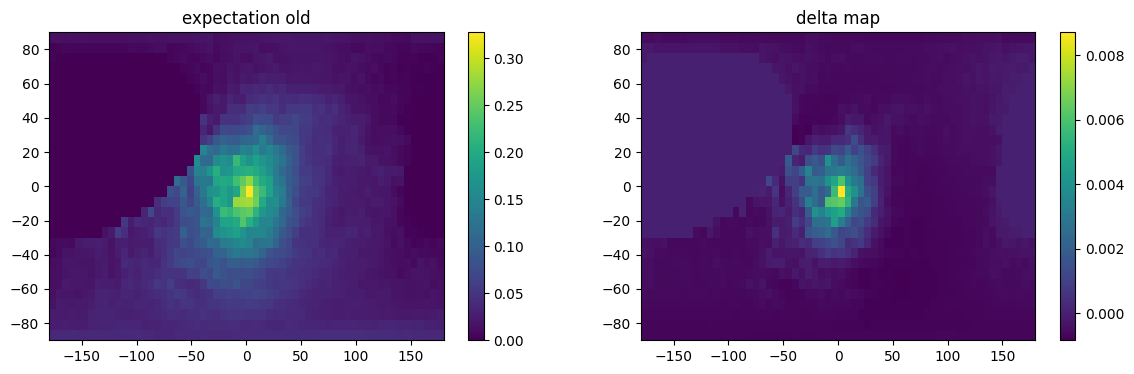

Convolving Delta image, iteration 40


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 40
Maximum acceleration parameter found:  8.614
Fitting delta-map in addition to old map, iteration 40
Proceeding without acceleration parameter.
Calculating Delta image, iteration 41, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

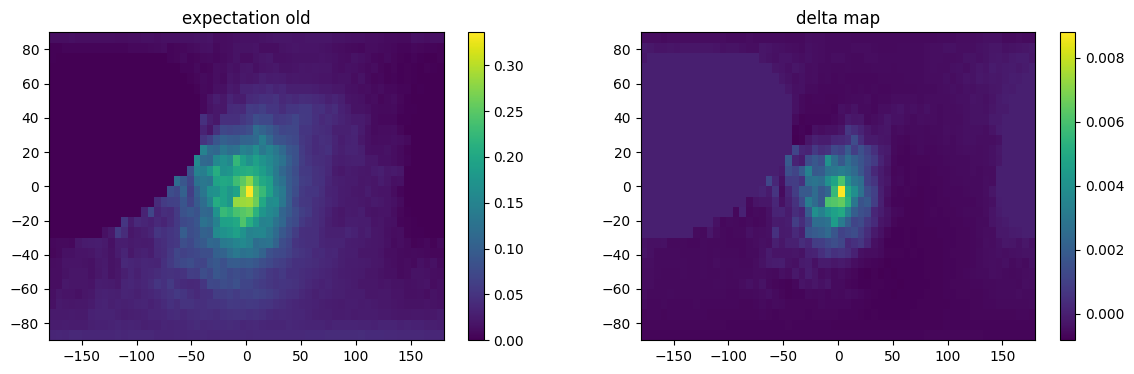

Convolving Delta image, iteration 41


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 41
Maximum acceleration parameter found:  8.635
Fitting delta-map in addition to old map, iteration 41
Proceeding without acceleration parameter.
Calculating Delta image, iteration 42, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

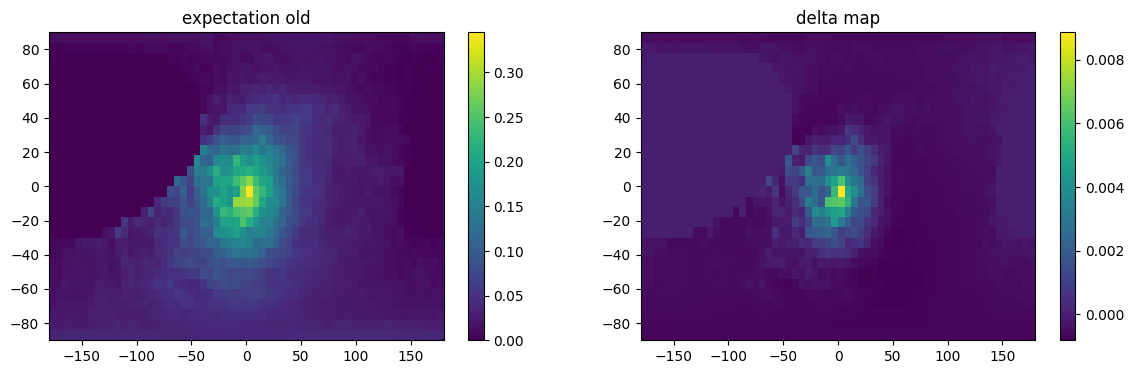

Convolving Delta image, iteration 42


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 42
Maximum acceleration parameter found:  8.656
Fitting delta-map in addition to old map, iteration 42
Proceeding without acceleration parameter.
Calculating Delta image, iteration 43, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

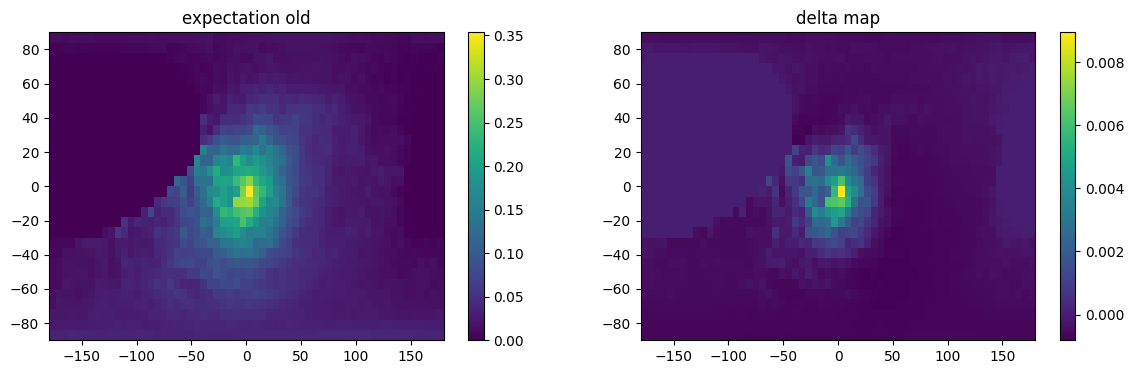

Convolving Delta image, iteration 43


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 43
Maximum acceleration parameter found:  8.676
Fitting delta-map in addition to old map, iteration 43
Proceeding without acceleration parameter.
Calculating Delta image, iteration 44, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

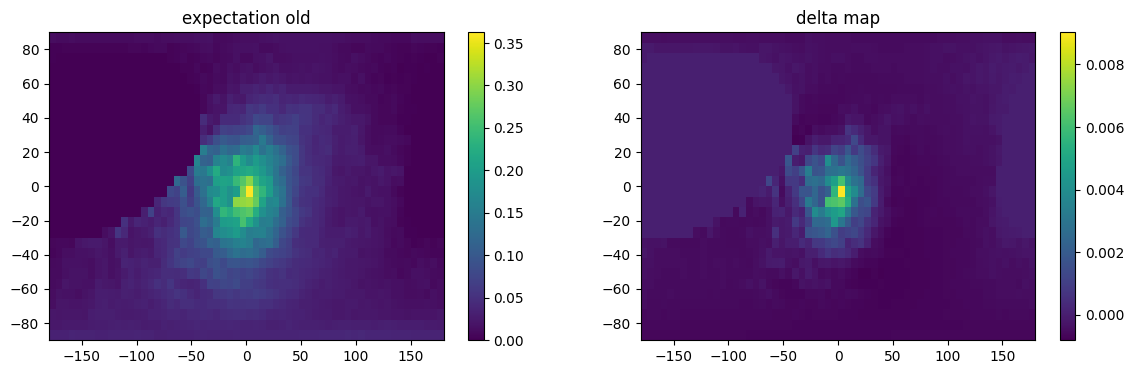

Convolving Delta image, iteration 44


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 44
Maximum acceleration parameter found:  8.697
Fitting delta-map in addition to old map, iteration 44
Proceeding without acceleration parameter.
Calculating Delta image, iteration 45, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

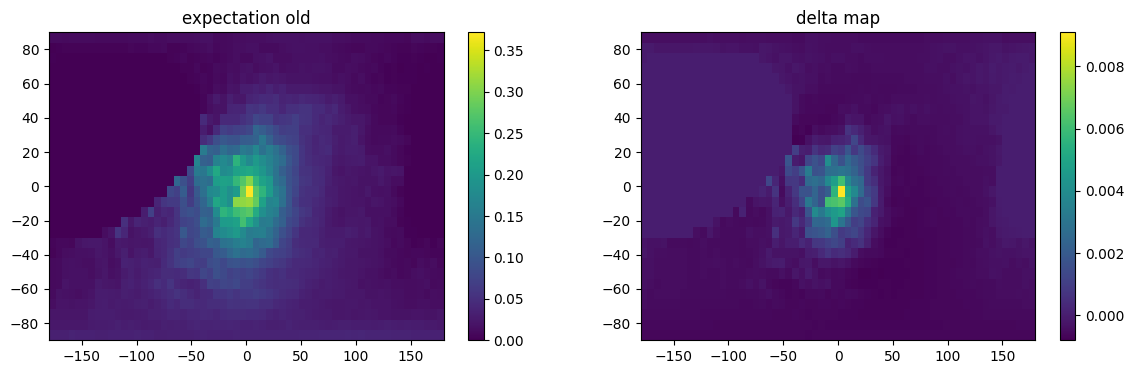

Convolving Delta image, iteration 45


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 45
Maximum acceleration parameter found:  8.717
Fitting delta-map in addition to old map, iteration 45
Proceeding without acceleration parameter.
Calculating Delta image, iteration 46, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

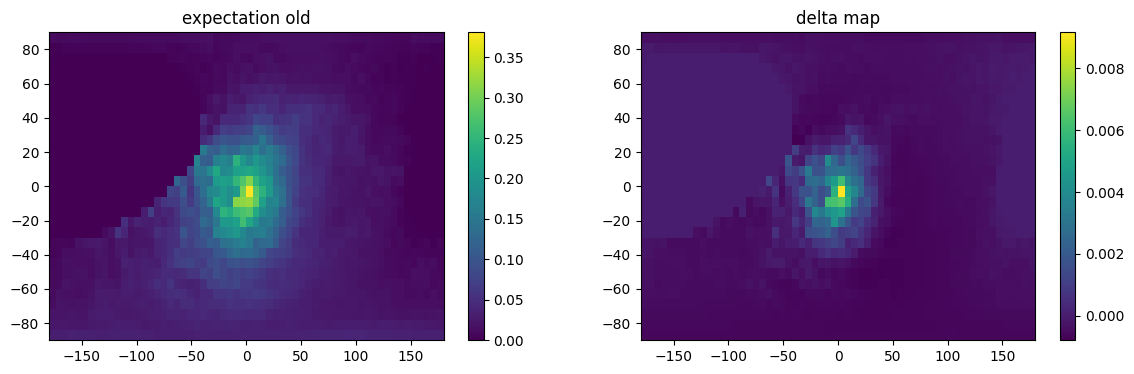

Convolving Delta image, iteration 46


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 46
Maximum acceleration parameter found:  8.737
Fitting delta-map in addition to old map, iteration 46
Proceeding without acceleration parameter.
Calculating Delta image, iteration 47, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

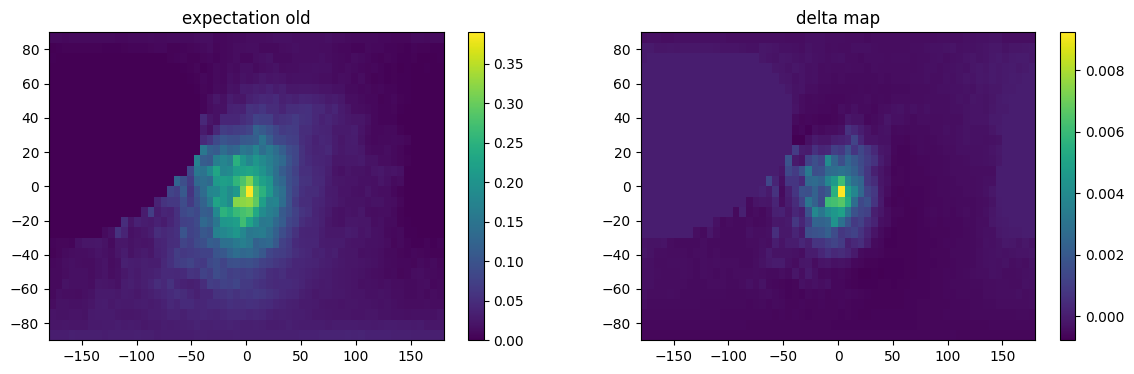

Convolving Delta image, iteration 47


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 47
Maximum acceleration parameter found:  8.757
Fitting delta-map in addition to old map, iteration 47
Proceeding without acceleration parameter.
Calculating Delta image, iteration 48, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

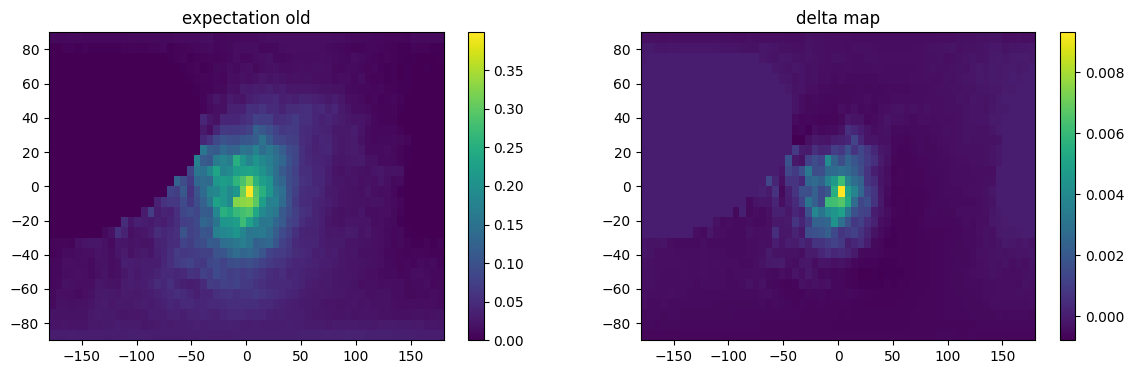

Convolving Delta image, iteration 48


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 48
Maximum acceleration parameter found:  8.776
Fitting delta-map in addition to old map, iteration 48
Proceeding without acceleration parameter.
Calculating Delta image, iteration 49, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

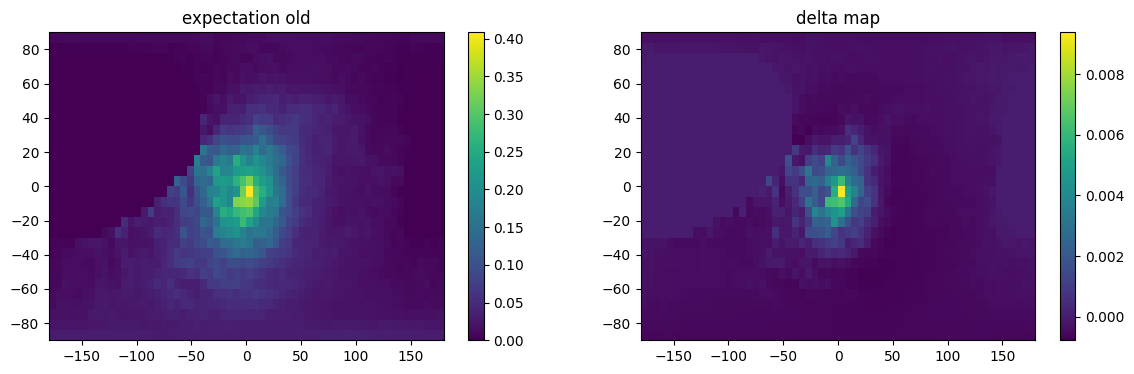

Convolving Delta image, iteration 49


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 49
Maximum acceleration parameter found:  8.796
Fitting delta-map in addition to old map, iteration 49
Proceeding without acceleration parameter.
Calculating Delta image, iteration 50, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

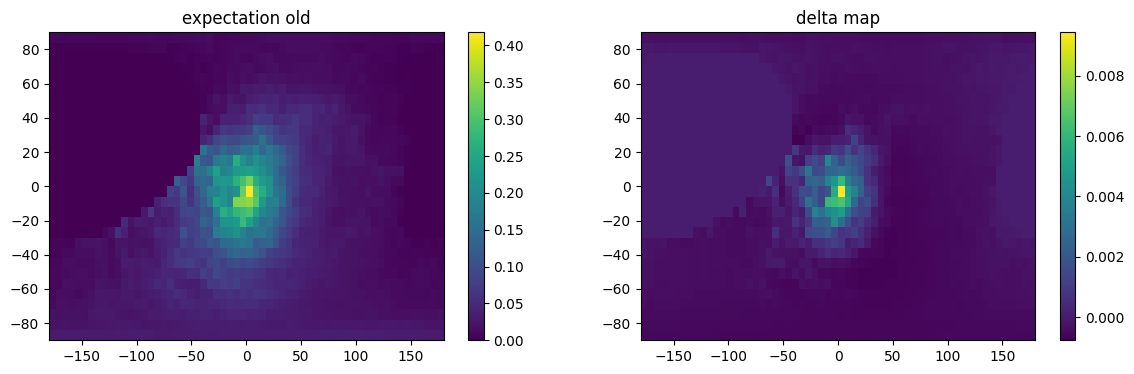

Convolving Delta image, iteration 50


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 50
Maximum acceleration parameter found:  8.815
Fitting delta-map in addition to old map, iteration 50
Proceeding without acceleration parameter.
Calculating Delta image, iteration 51, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

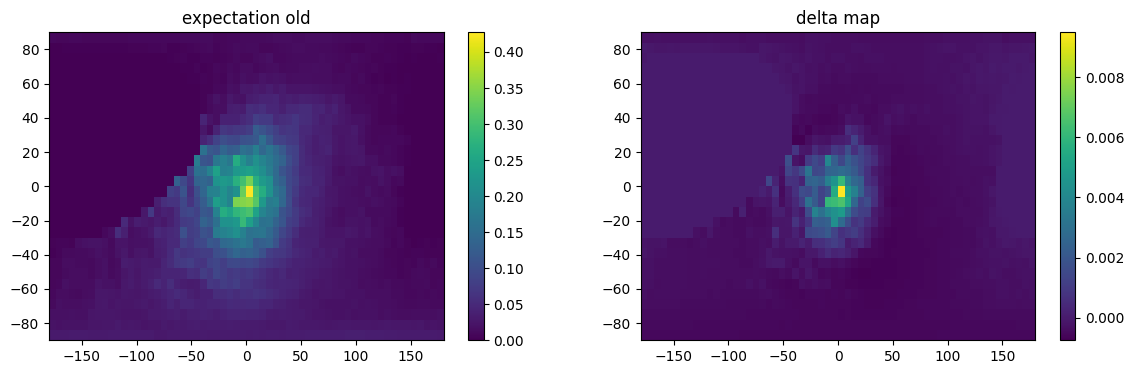

Convolving Delta image, iteration 51


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 51
Maximum acceleration parameter found:  8.834
Fitting delta-map in addition to old map, iteration 51
Proceeding without acceleration parameter.
Calculating Delta image, iteration 52, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

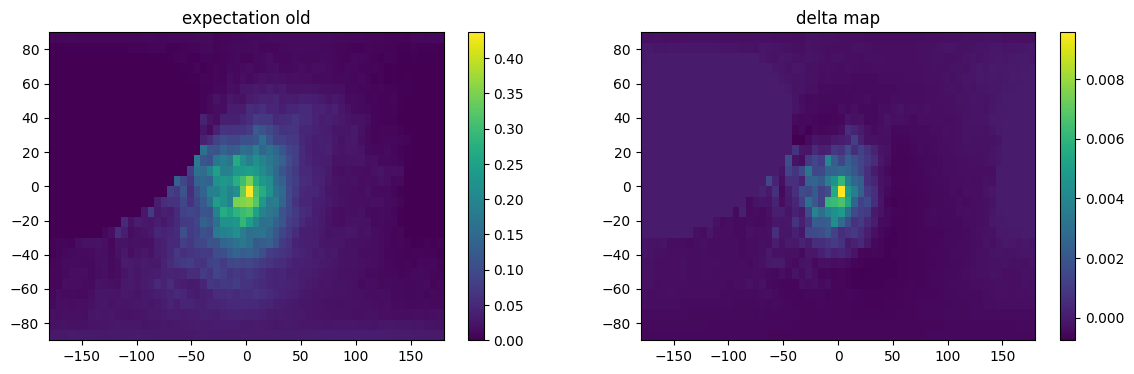

Convolving Delta image, iteration 52


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 52
Maximum acceleration parameter found:  8.853
Fitting delta-map in addition to old map, iteration 52
Proceeding without acceleration parameter.
Calculating Delta image, iteration 53, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

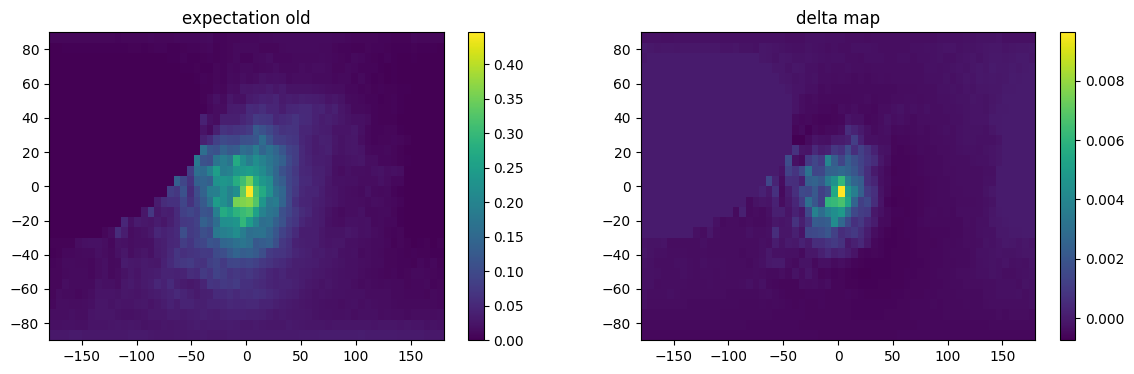

Convolving Delta image, iteration 53


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 53
Maximum acceleration parameter found:  8.872
Fitting delta-map in addition to old map, iteration 53
Proceeding without acceleration parameter.
Calculating Delta image, iteration 54, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

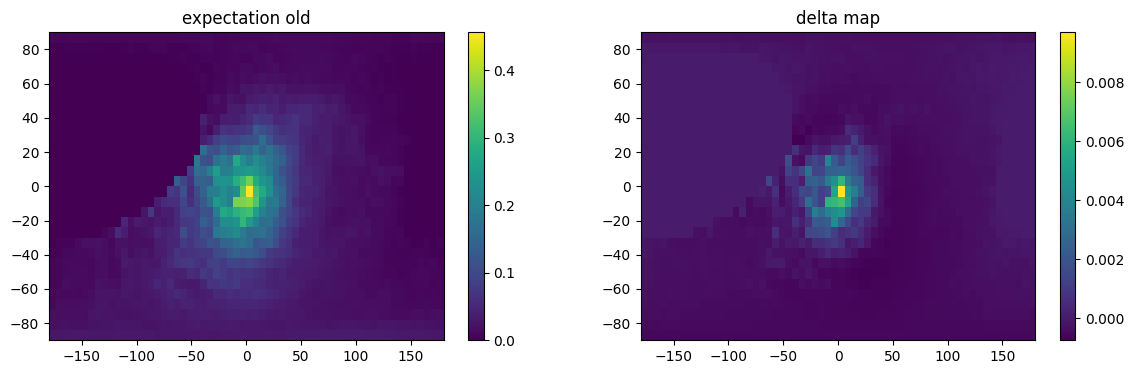

Convolving Delta image, iteration 54


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 54
Maximum acceleration parameter found:  8.891
Fitting delta-map in addition to old map, iteration 54
Proceeding without acceleration parameter.
Calculating Delta image, iteration 55, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

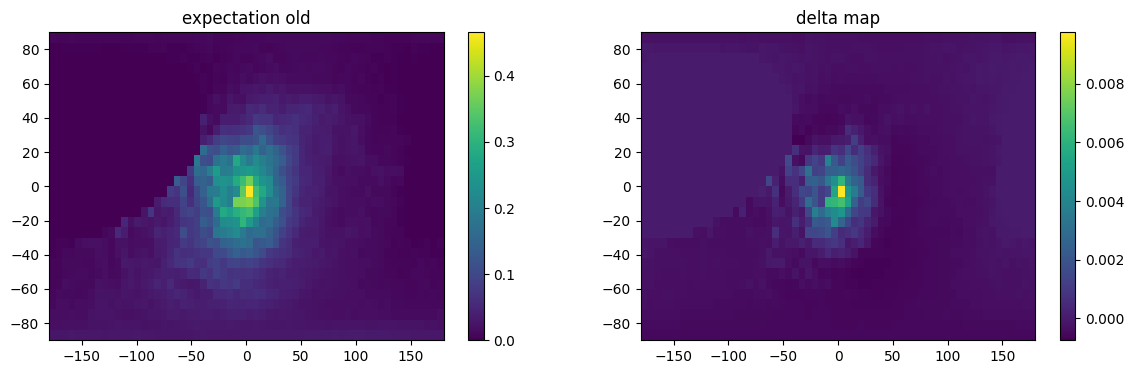

Convolving Delta image, iteration 55


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 55
Maximum acceleration parameter found:  8.909
Fitting delta-map in addition to old map, iteration 55
Proceeding without acceleration parameter.
Calculating Delta image, iteration 56, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

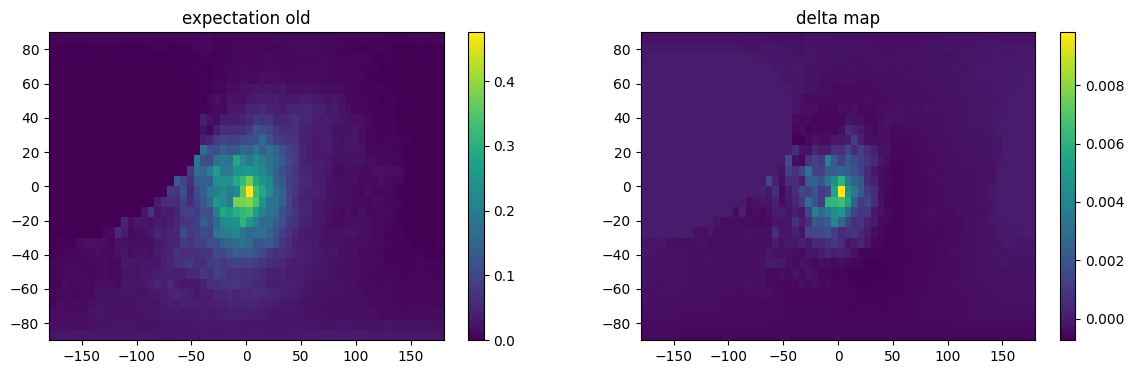

Convolving Delta image, iteration 56


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 56
Maximum acceleration parameter found:  8.927
Fitting delta-map in addition to old map, iteration 56
Proceeding without acceleration parameter.
Calculating Delta image, iteration 57, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

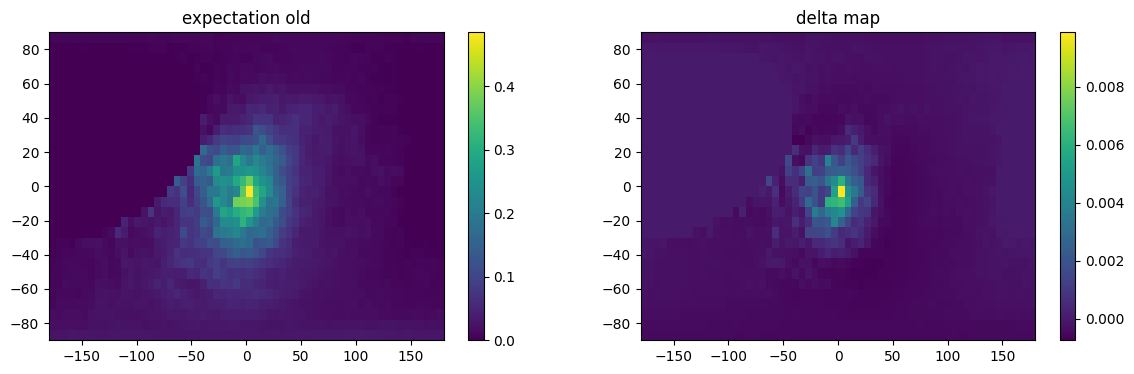

Convolving Delta image, iteration 57


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 57
Maximum acceleration parameter found:  8.945
Fitting delta-map in addition to old map, iteration 57
Proceeding without acceleration parameter.
Calculating Delta image, iteration 58, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

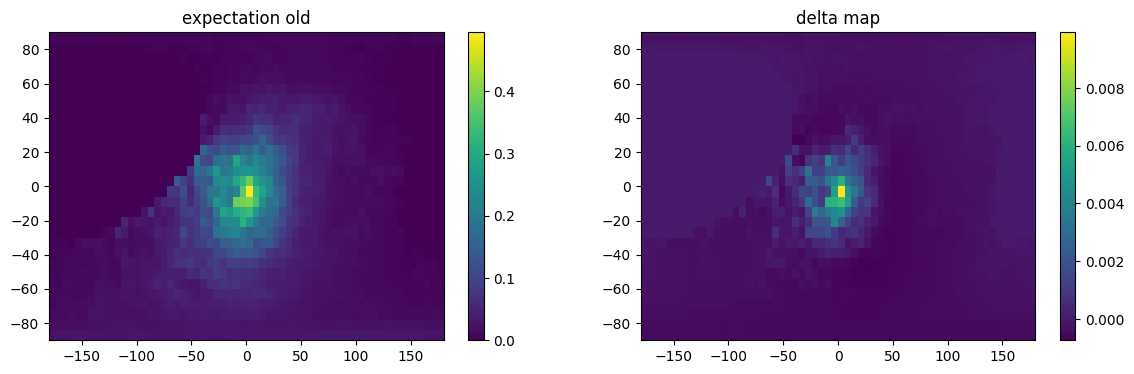

Convolving Delta image, iteration 58


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 58
Maximum acceleration parameter found:  8.963
Fitting delta-map in addition to old map, iteration 58
Proceeding without acceleration parameter.
Calculating Delta image, iteration 59, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

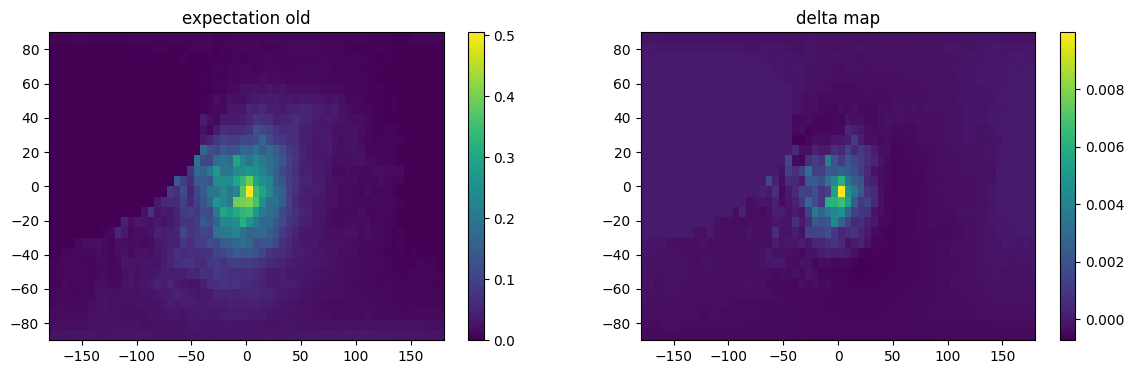

Convolving Delta image, iteration 59


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 59
Maximum acceleration parameter found:  8.981
Fitting delta-map in addition to old map, iteration 59
Proceeding without acceleration parameter.
Calculating Delta image, iteration 60, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

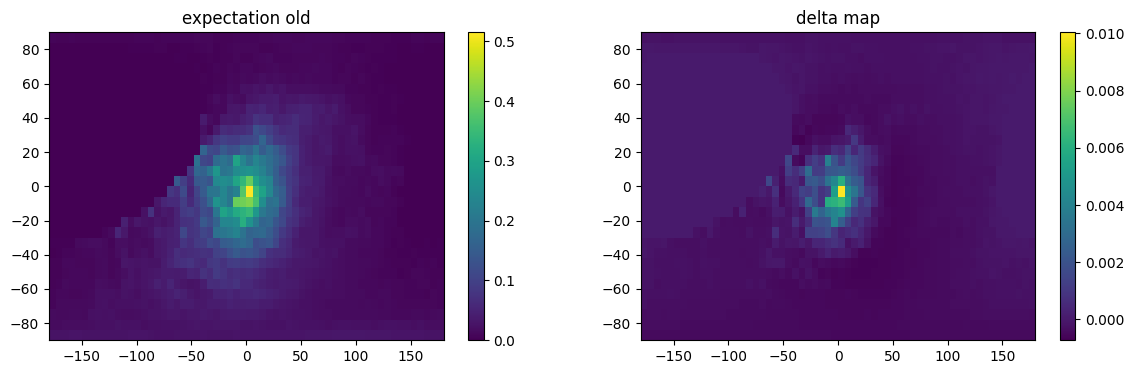

Convolving Delta image, iteration 60


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 60
Maximum acceleration parameter found:  8.998
Fitting delta-map in addition to old map, iteration 60
Proceeding without acceleration parameter.
Calculating Delta image, iteration 61, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

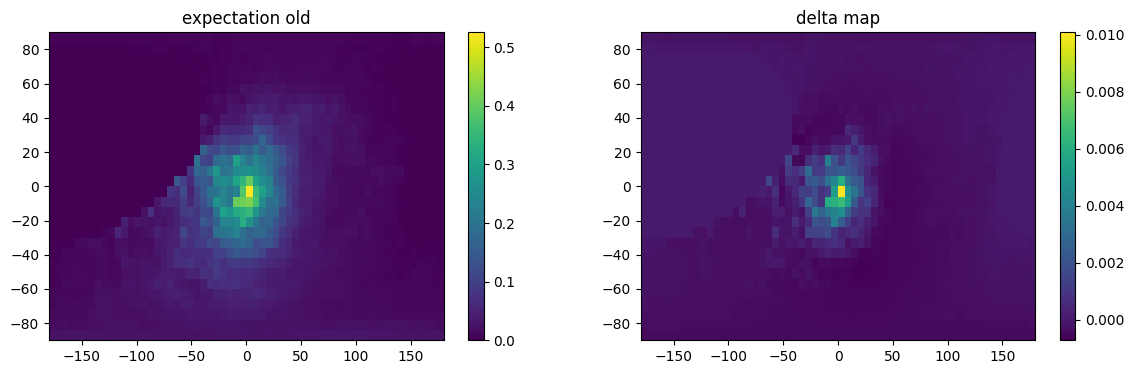

Convolving Delta image, iteration 61


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 61
Maximum acceleration parameter found:  9.016
Fitting delta-map in addition to old map, iteration 61
Proceeding without acceleration parameter.
Calculating Delta image, iteration 62, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

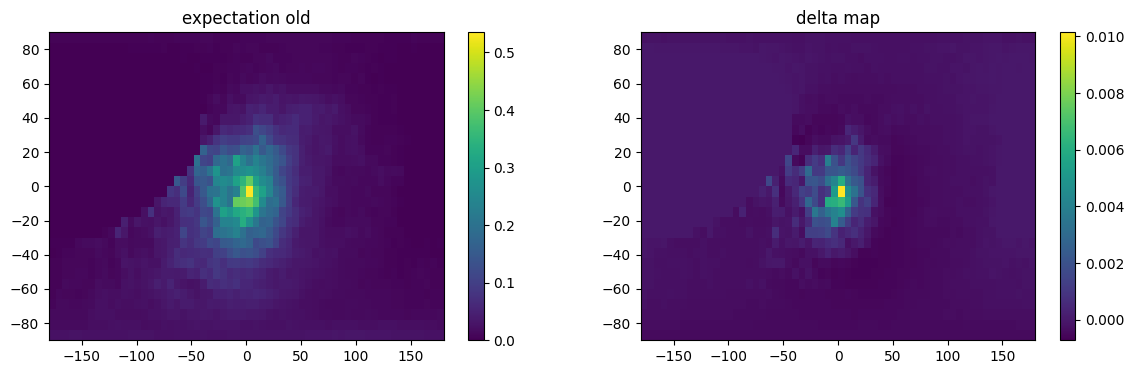

Convolving Delta image, iteration 62


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 62
Maximum acceleration parameter found:  9.033
Fitting delta-map in addition to old map, iteration 62
Proceeding without acceleration parameter.
Calculating Delta image, iteration 63, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

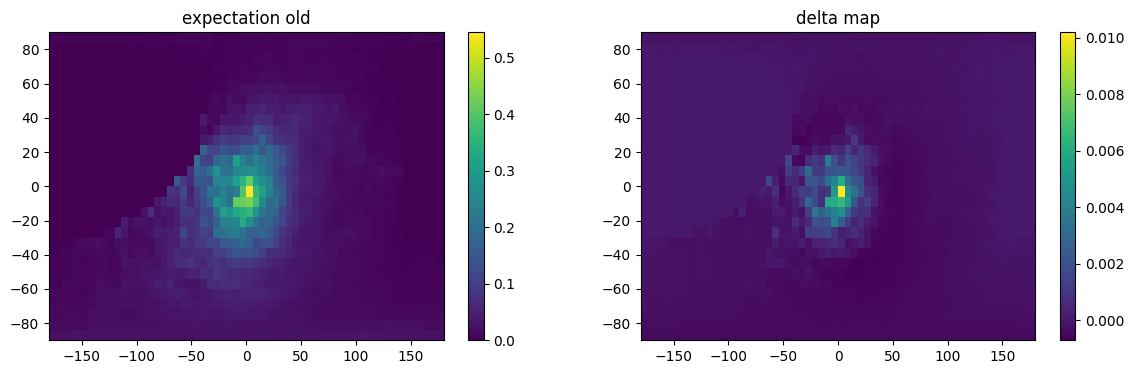

Convolving Delta image, iteration 63


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 63
Maximum acceleration parameter found:  9.05
Fitting delta-map in addition to old map, iteration 63
Proceeding without acceleration parameter.
Calculating Delta image, iteration 64, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

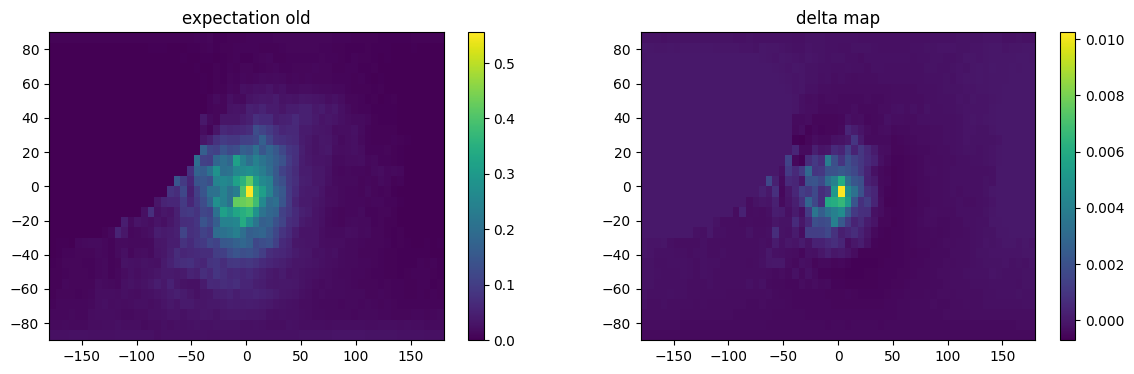

Convolving Delta image, iteration 64


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 64
Maximum acceleration parameter found:  9.066
Fitting delta-map in addition to old map, iteration 64
Proceeding without acceleration parameter.
Calculating Delta image, iteration 65, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

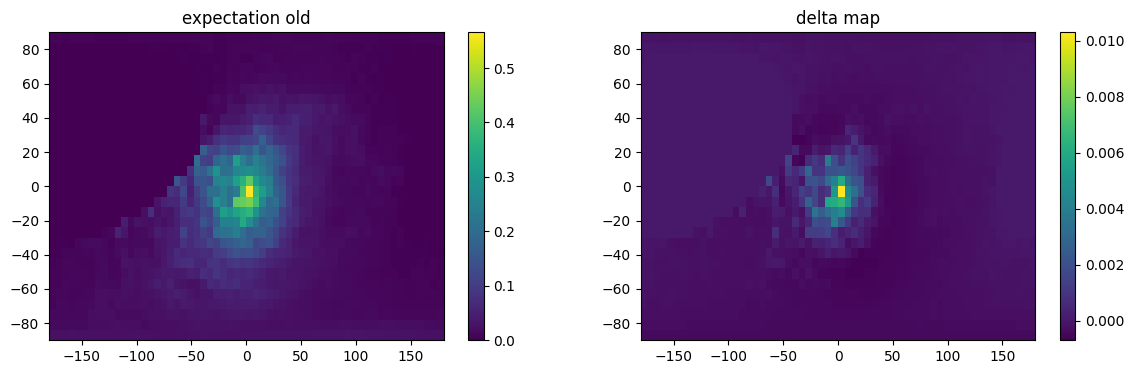

Convolving Delta image, iteration 65


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 65
Maximum acceleration parameter found:  9.083
Fitting delta-map in addition to old map, iteration 65
Proceeding without acceleration parameter.
Calculating Delta image, iteration 66, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

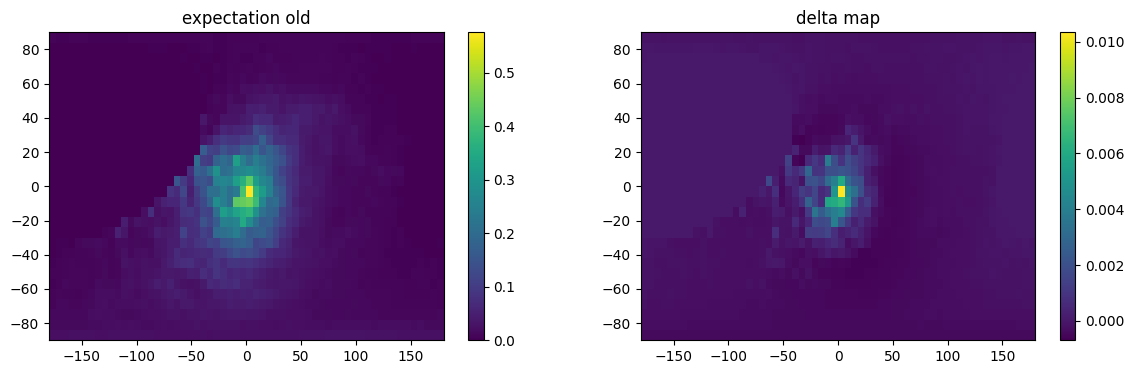

Convolving Delta image, iteration 66


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 66
Maximum acceleration parameter found:  9.099
Fitting delta-map in addition to old map, iteration 66
Proceeding without acceleration parameter.
Calculating Delta image, iteration 67, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

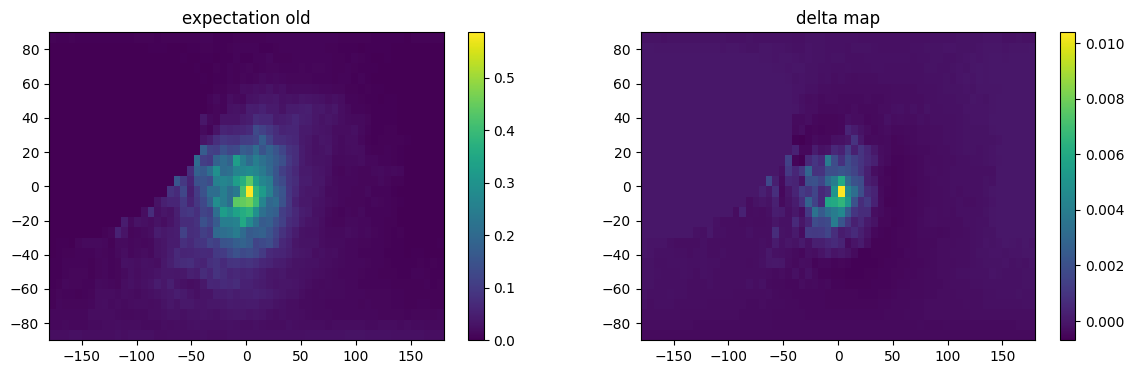

Convolving Delta image, iteration 67


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 67
Maximum acceleration parameter found:  9.116
Fitting delta-map in addition to old map, iteration 67
Proceeding without acceleration parameter.
Calculating Delta image, iteration 68, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

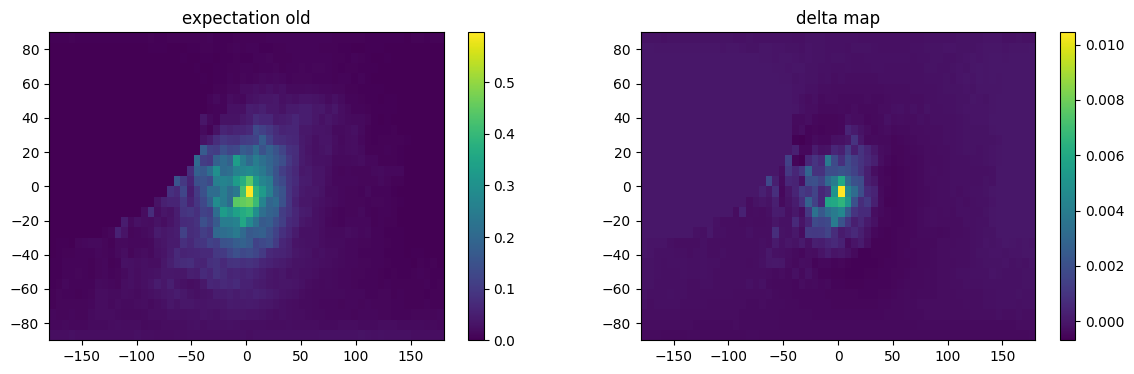

Convolving Delta image, iteration 68


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 68
Maximum acceleration parameter found:  9.132
Fitting delta-map in addition to old map, iteration 68
Proceeding without acceleration parameter.
Calculating Delta image, iteration 69, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

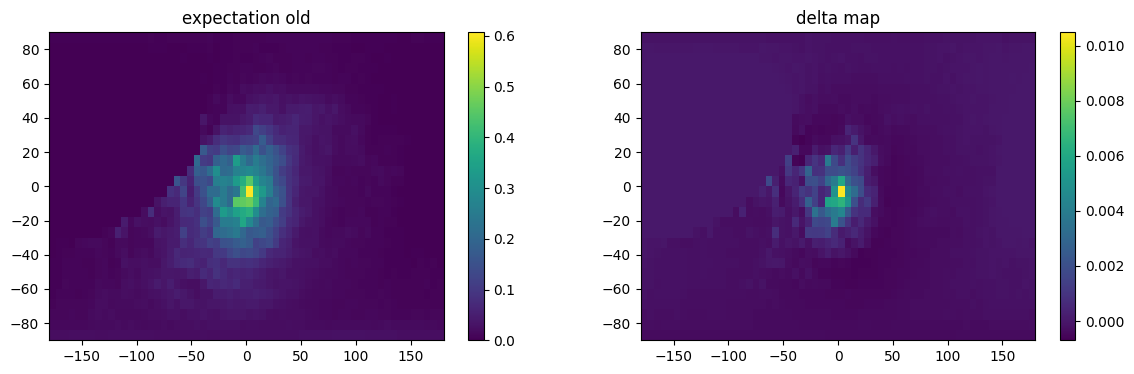

Convolving Delta image, iteration 69


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 69
Maximum acceleration parameter found:  9.147
Fitting delta-map in addition to old map, iteration 69
Proceeding without acceleration parameter.
Calculating Delta image, iteration 70, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

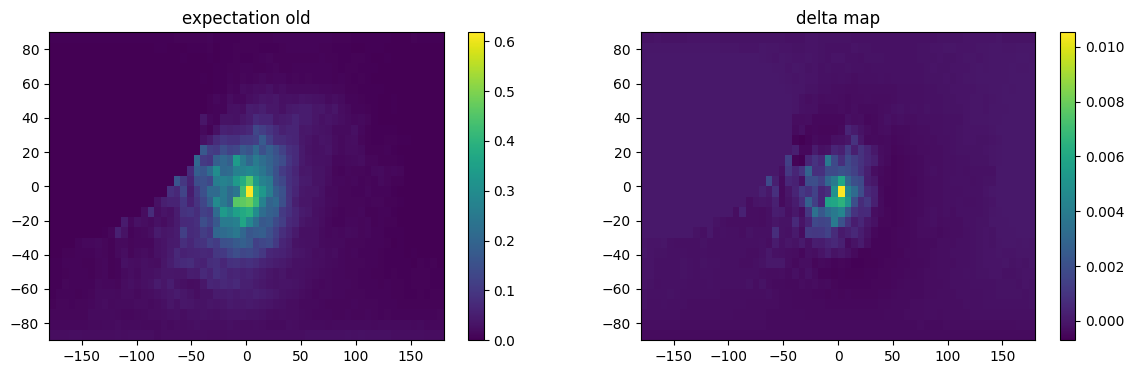

Convolving Delta image, iteration 70


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 70
Maximum acceleration parameter found:  9.163
Fitting delta-map in addition to old map, iteration 70
Proceeding without acceleration parameter.
Calculating Delta image, iteration 71, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

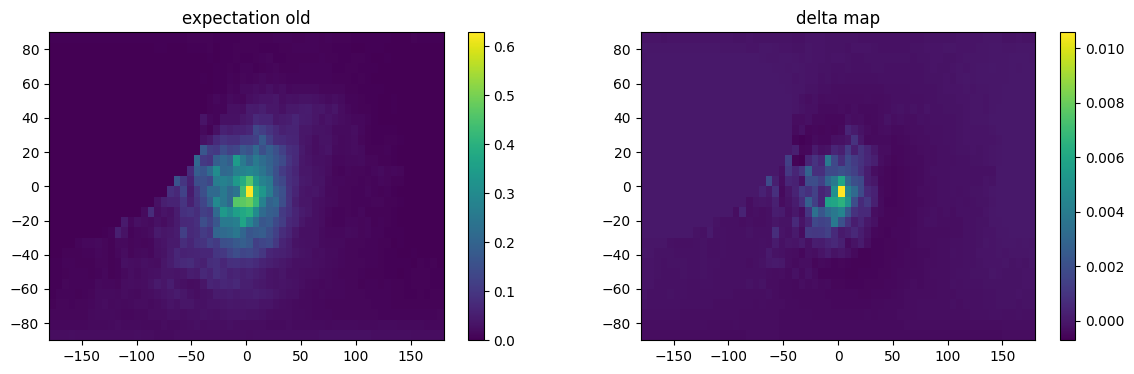

Convolving Delta image, iteration 71


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 71
Maximum acceleration parameter found:  9.178
Fitting delta-map in addition to old map, iteration 71
Proceeding without acceleration parameter.
Calculating Delta image, iteration 72, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

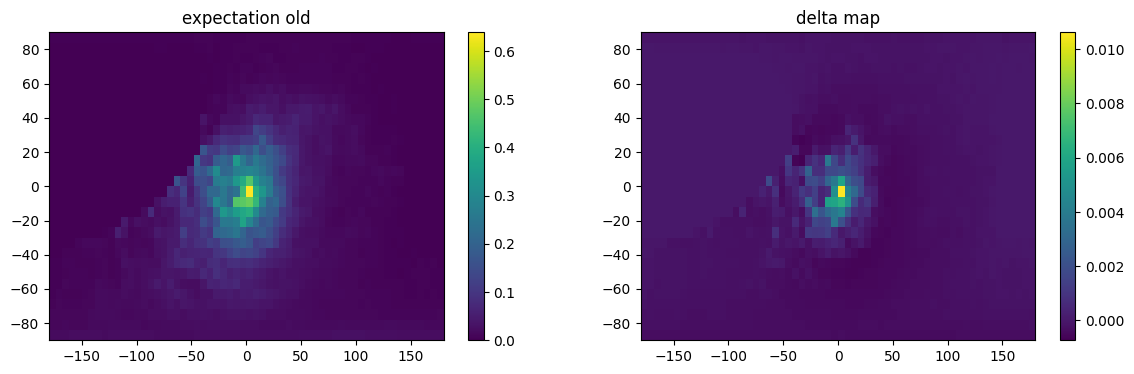

Convolving Delta image, iteration 72


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 72
Maximum acceleration parameter found:  9.194
Fitting delta-map in addition to old map, iteration 72
Proceeding without acceleration parameter.
Calculating Delta image, iteration 73, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

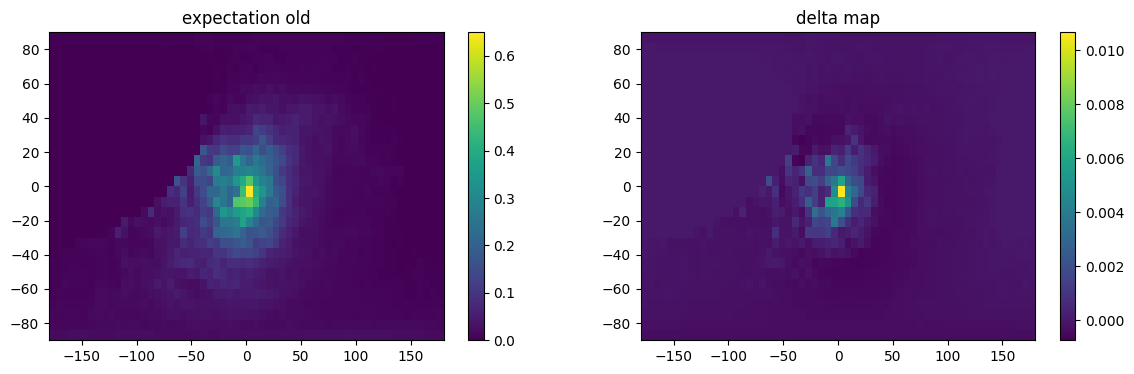

Convolving Delta image, iteration 73


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 73
Maximum acceleration parameter found:  9.209
Fitting delta-map in addition to old map, iteration 73
Proceeding without acceleration parameter.
Calculating Delta image, iteration 74, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

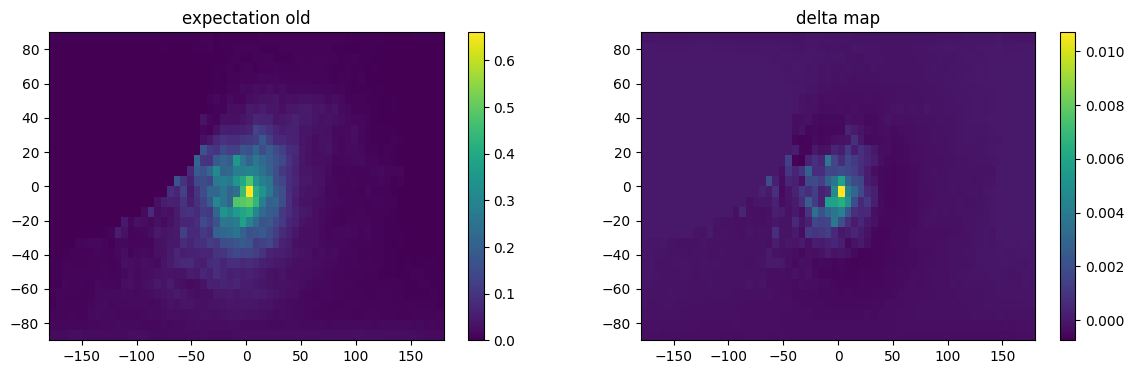

Convolving Delta image, iteration 74


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 74
Maximum acceleration parameter found:  9.224
Fitting delta-map in addition to old map, iteration 74
Proceeding without acceleration parameter.
Calculating Delta image, iteration 75, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

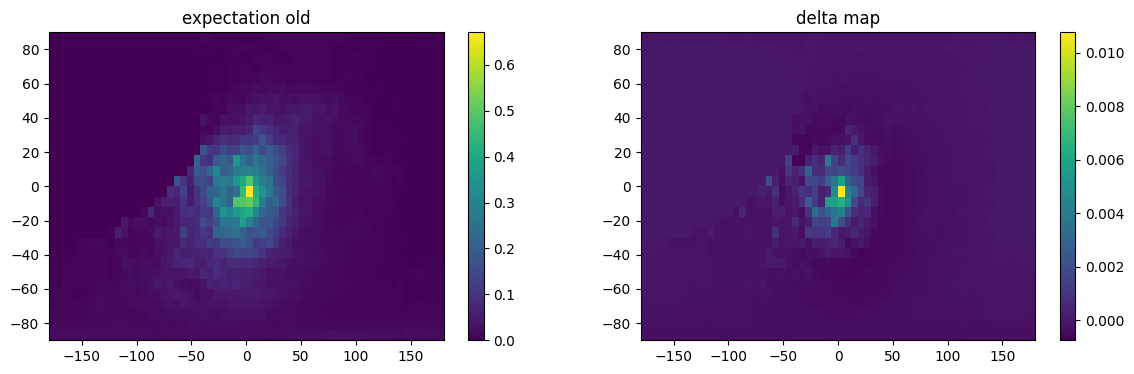

Convolving Delta image, iteration 75


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 75
Maximum acceleration parameter found:  9.239
Fitting delta-map in addition to old map, iteration 75
Proceeding without acceleration parameter.
Calculating Delta image, iteration 76, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

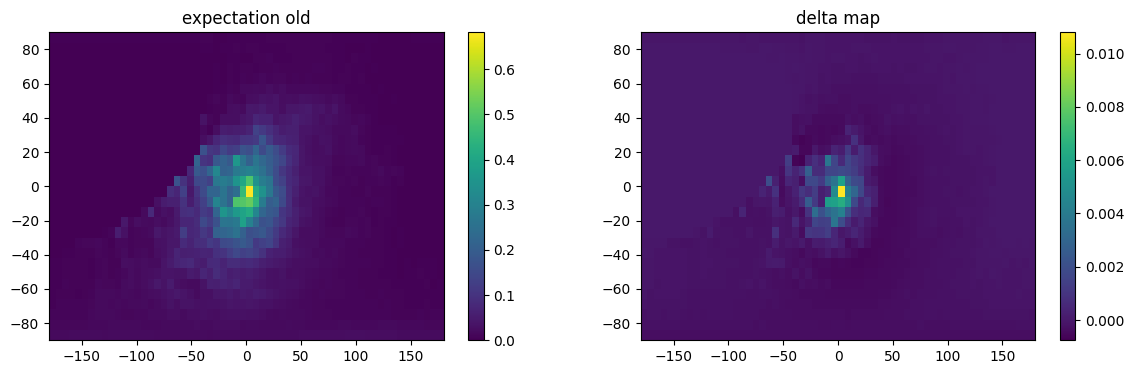

Convolving Delta image, iteration 76


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 76
Maximum acceleration parameter found:  9.253
Fitting delta-map in addition to old map, iteration 76
Proceeding without acceleration parameter.
Calculating Delta image, iteration 77, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

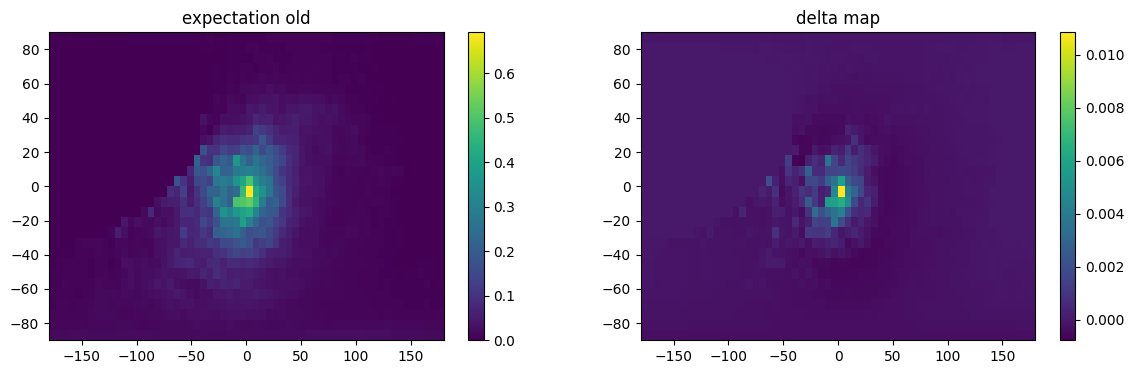

Convolving Delta image, iteration 77


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 77
Maximum acceleration parameter found:  9.268
Fitting delta-map in addition to old map, iteration 77
Proceeding without acceleration parameter.
Calculating Delta image, iteration 78, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

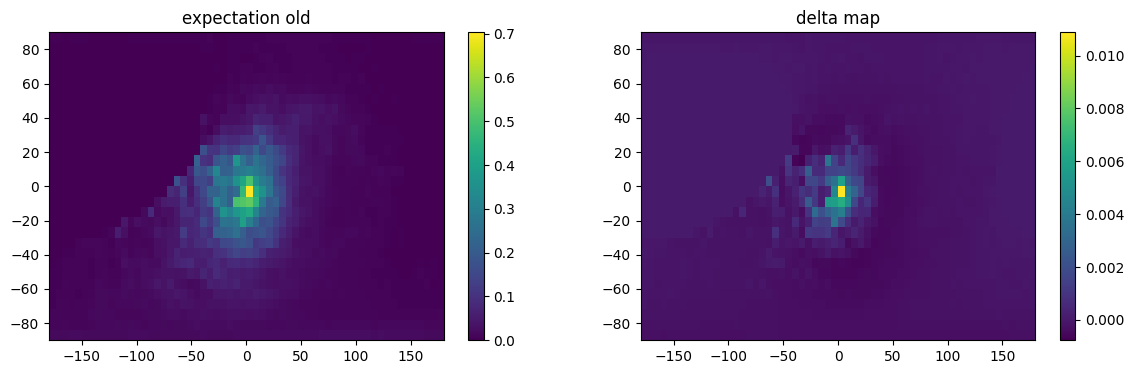

Convolving Delta image, iteration 78


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 78
Maximum acceleration parameter found:  9.282
Fitting delta-map in addition to old map, iteration 78
Proceeding without acceleration parameter.
Calculating Delta image, iteration 79, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

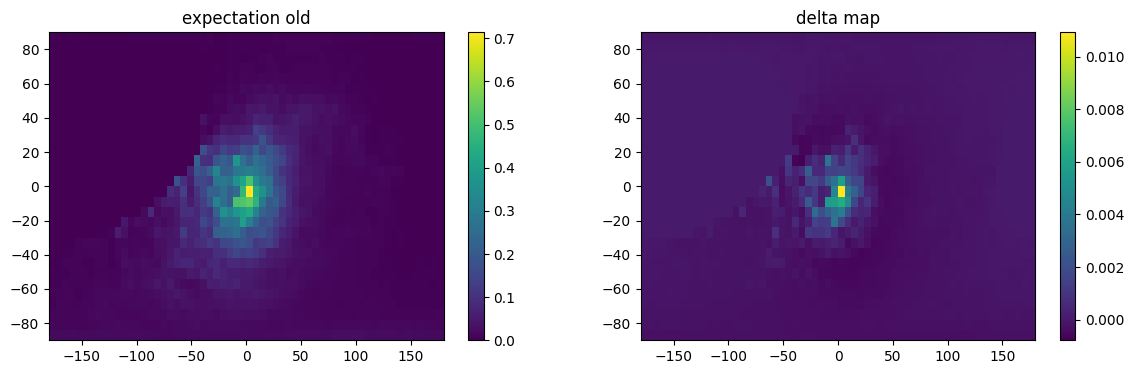

Convolving Delta image, iteration 79


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 79
Maximum acceleration parameter found:  9.296
Fitting delta-map in addition to old map, iteration 79
Proceeding without acceleration parameter.
Calculating Delta image, iteration 80, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

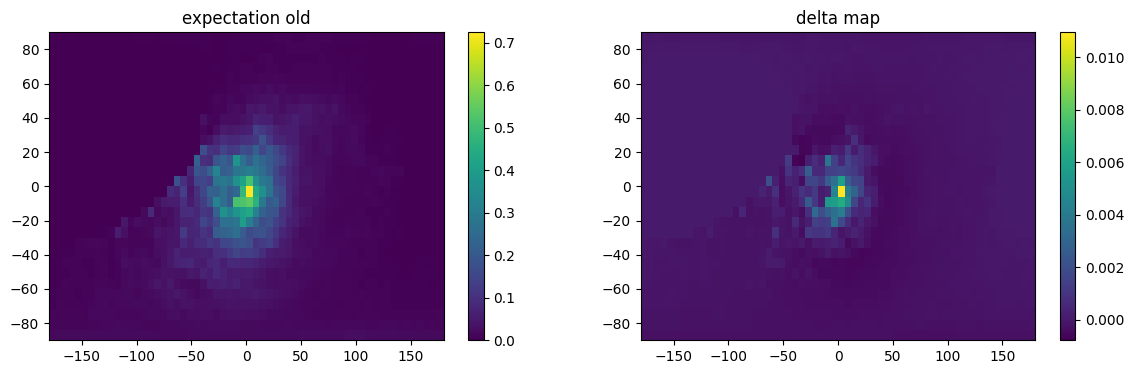

Convolving Delta image, iteration 80


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 80
Maximum acceleration parameter found:  9.31
Fitting delta-map in addition to old map, iteration 80
Proceeding without acceleration parameter.
Calculating Delta image, iteration 81, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

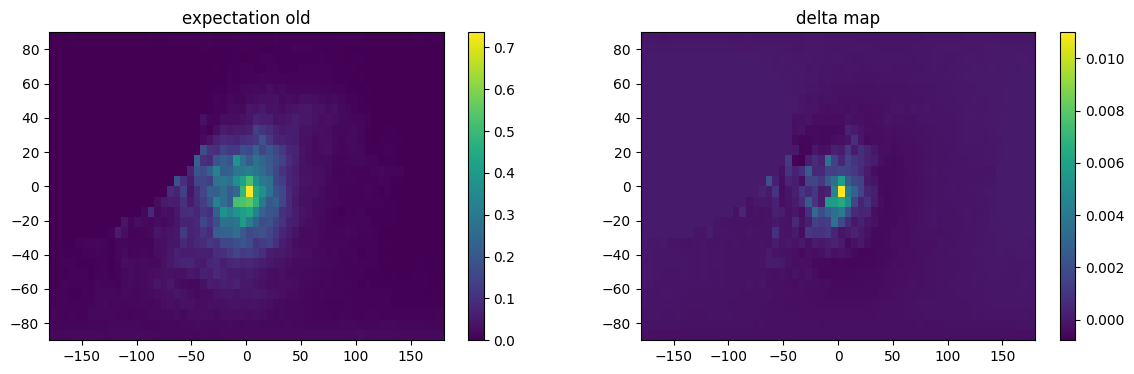

Convolving Delta image, iteration 81


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 81
Maximum acceleration parameter found:  9.324
Fitting delta-map in addition to old map, iteration 81
Proceeding without acceleration parameter.
Calculating Delta image, iteration 82, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

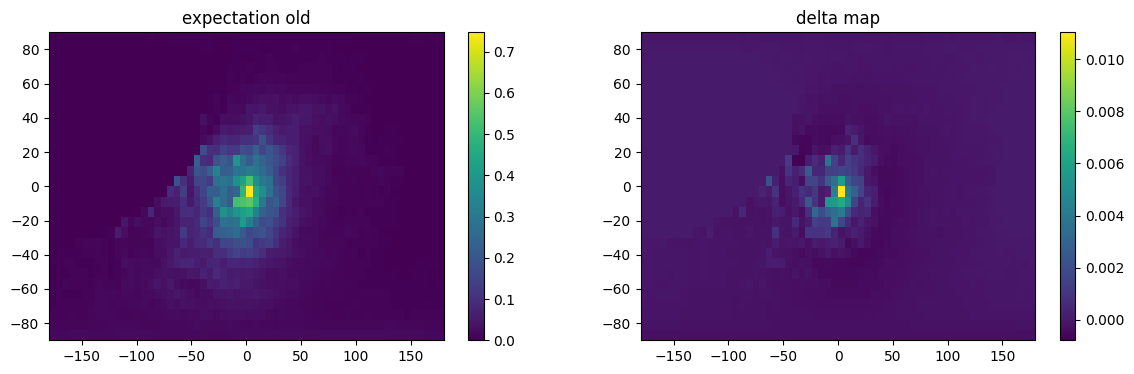

Convolving Delta image, iteration 82


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 82
Maximum acceleration parameter found:  9.337
Fitting delta-map in addition to old map, iteration 82
Proceeding without acceleration parameter.
Calculating Delta image, iteration 83, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

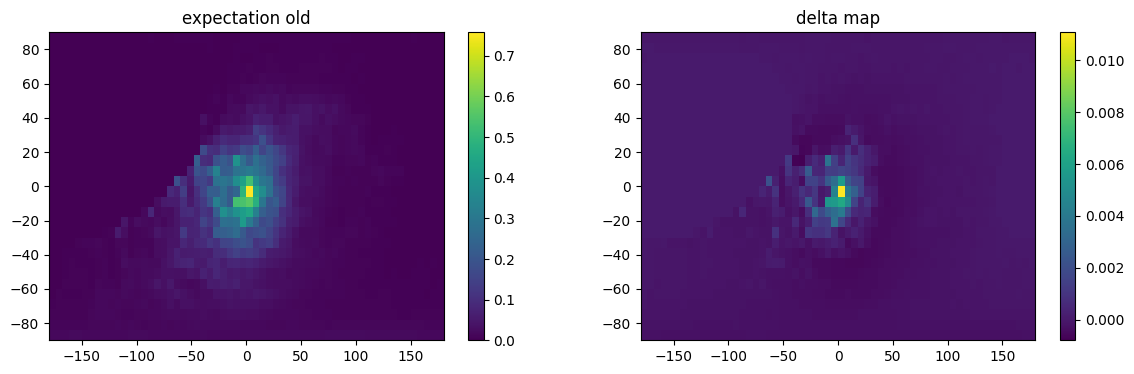

Convolving Delta image, iteration 83


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 83
Maximum acceleration parameter found:  9.351
Fitting delta-map in addition to old map, iteration 83
Proceeding without acceleration parameter.
Calculating Delta image, iteration 84, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

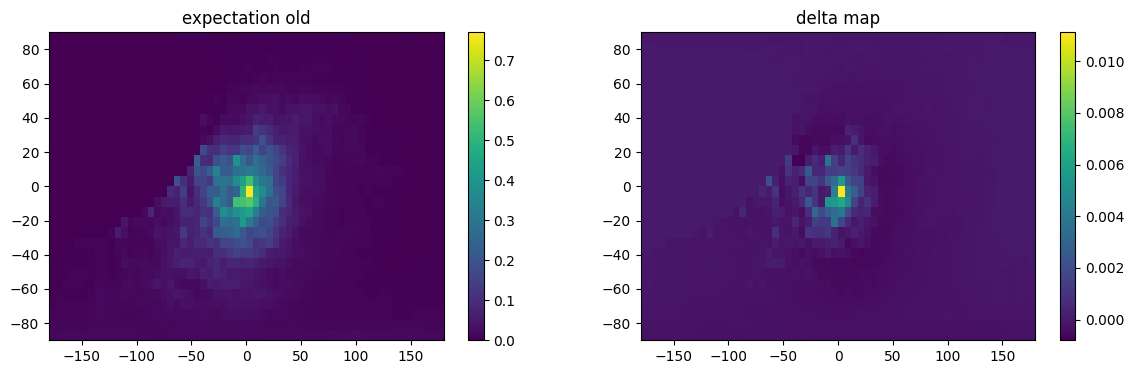

Convolving Delta image, iteration 84


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 84
Maximum acceleration parameter found:  9.364
Fitting delta-map in addition to old map, iteration 84
Proceeding without acceleration parameter.
Calculating Delta image, iteration 85, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

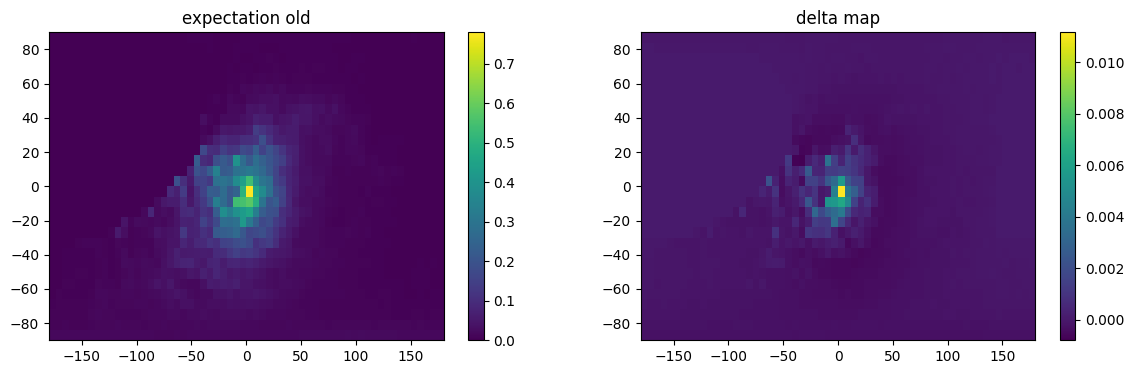

Convolving Delta image, iteration 85


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 85
Maximum acceleration parameter found:  9.377
Fitting delta-map in addition to old map, iteration 85
Proceeding without acceleration parameter.
Calculating Delta image, iteration 86, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

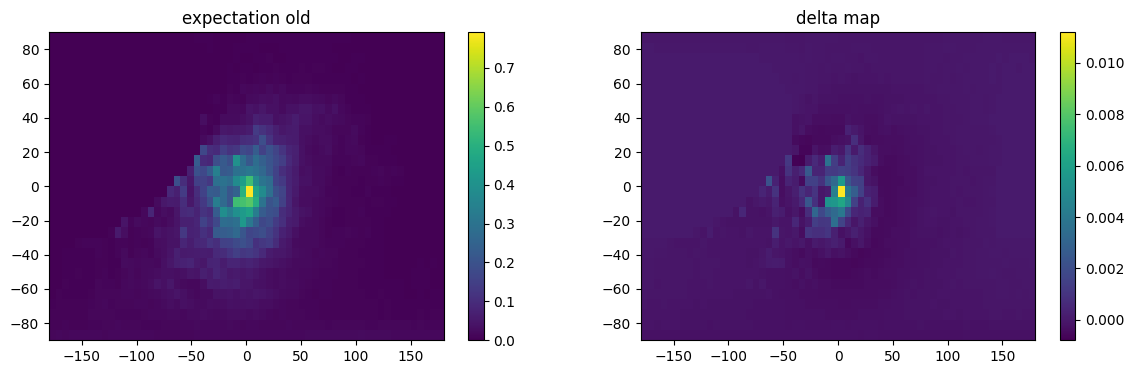

Convolving Delta image, iteration 86


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 86
Maximum acceleration parameter found:  9.39
Fitting delta-map in addition to old map, iteration 86
Proceeding without acceleration parameter.
Calculating Delta image, iteration 87, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

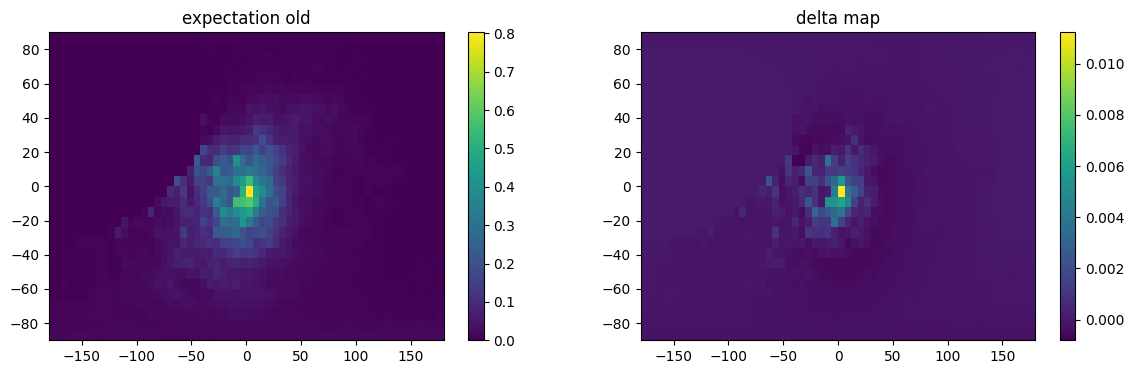

Convolving Delta image, iteration 87


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 87
Maximum acceleration parameter found:  9.403
Fitting delta-map in addition to old map, iteration 87
Proceeding without acceleration parameter.
Calculating Delta image, iteration 88, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

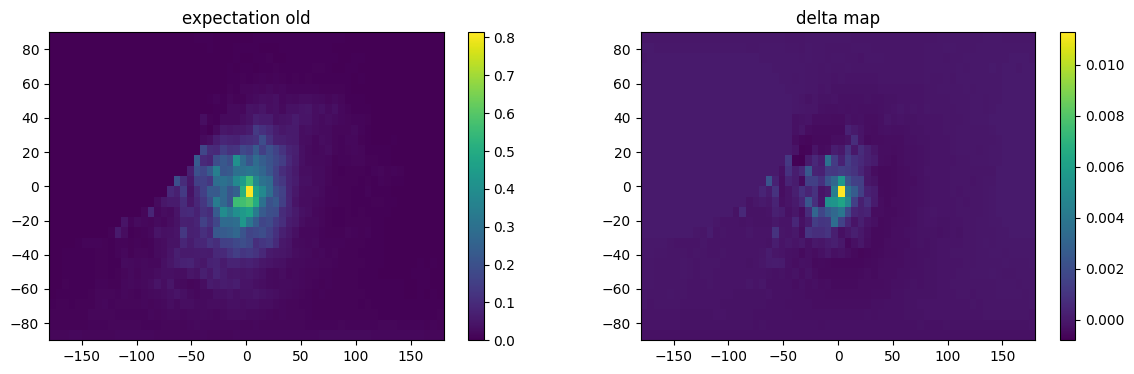

Convolving Delta image, iteration 88


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 88
Maximum acceleration parameter found:  9.416
Fitting delta-map in addition to old map, iteration 88
Proceeding without acceleration parameter.
Calculating Delta image, iteration 89, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

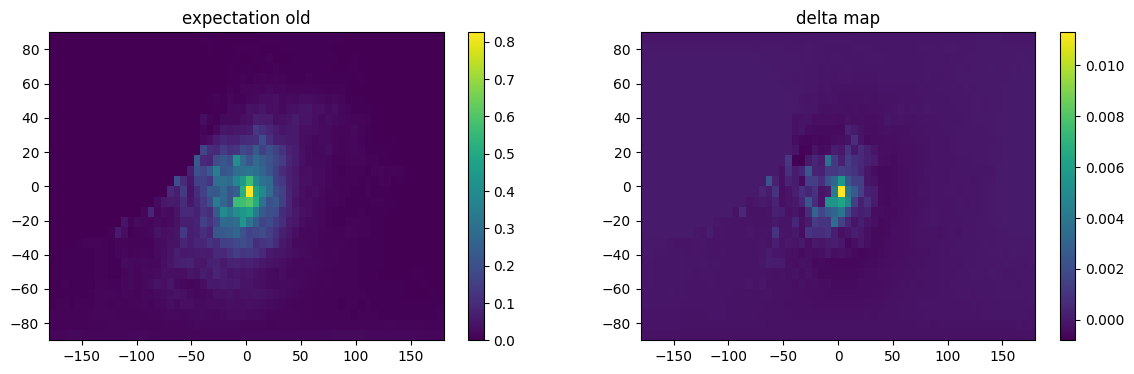

Convolving Delta image, iteration 89


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 89
Maximum acceleration parameter found:  9.428
Fitting delta-map in addition to old map, iteration 89
Proceeding without acceleration parameter.
Calculating Delta image, iteration 90, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

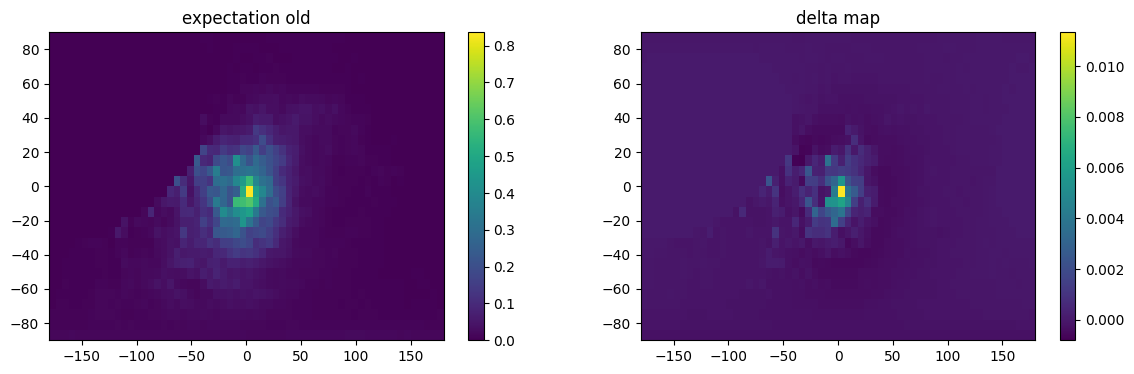

Convolving Delta image, iteration 90


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 90
Maximum acceleration parameter found:  9.441
Fitting delta-map in addition to old map, iteration 90
Proceeding without acceleration parameter.
Calculating Delta image, iteration 91, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

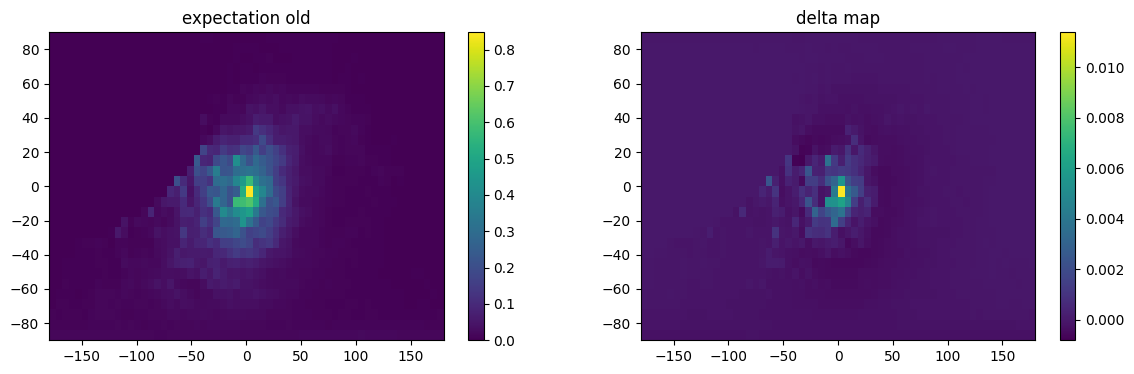

Convolving Delta image, iteration 91


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 91
Maximum acceleration parameter found:  9.453
Fitting delta-map in addition to old map, iteration 91
Proceeding without acceleration parameter.
Calculating Delta image, iteration 92, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

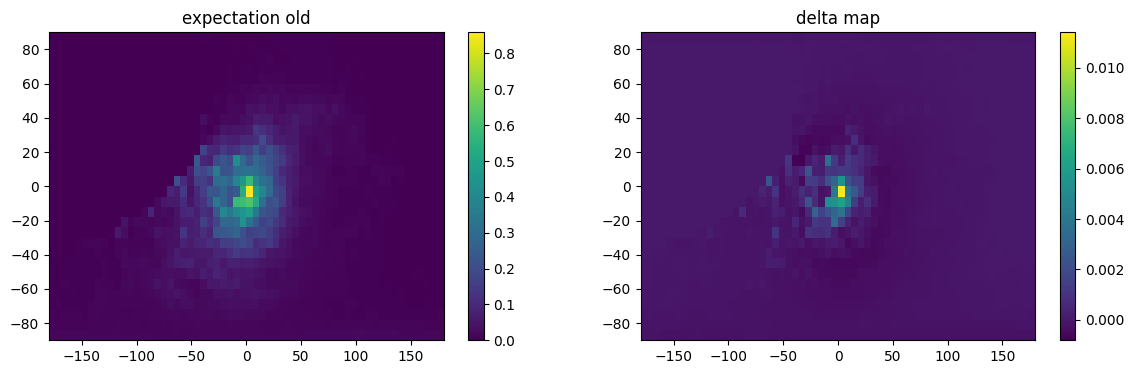

Convolving Delta image, iteration 92


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 92
Maximum acceleration parameter found:  9.465
Fitting delta-map in addition to old map, iteration 92
Proceeding without acceleration parameter.
Calculating Delta image, iteration 93, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

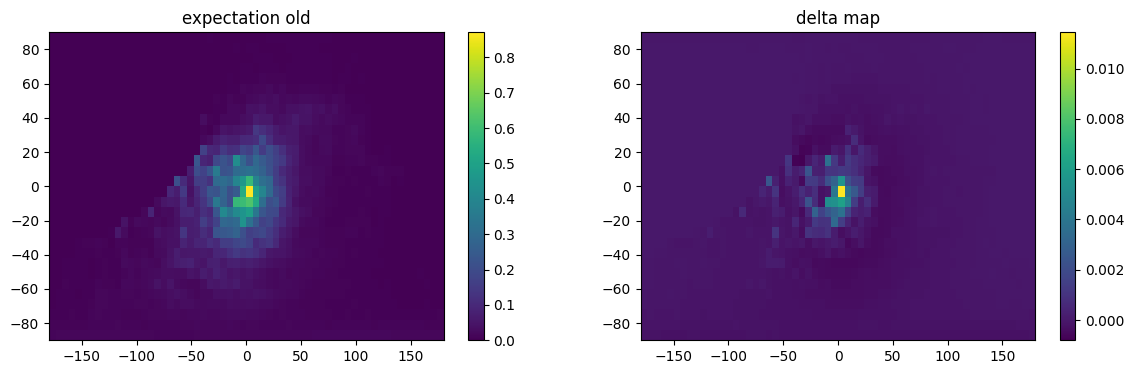

Convolving Delta image, iteration 93


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 93
Maximum acceleration parameter found:  9.477
Fitting delta-map in addition to old map, iteration 93
Proceeding without acceleration parameter.
Calculating Delta image, iteration 94, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

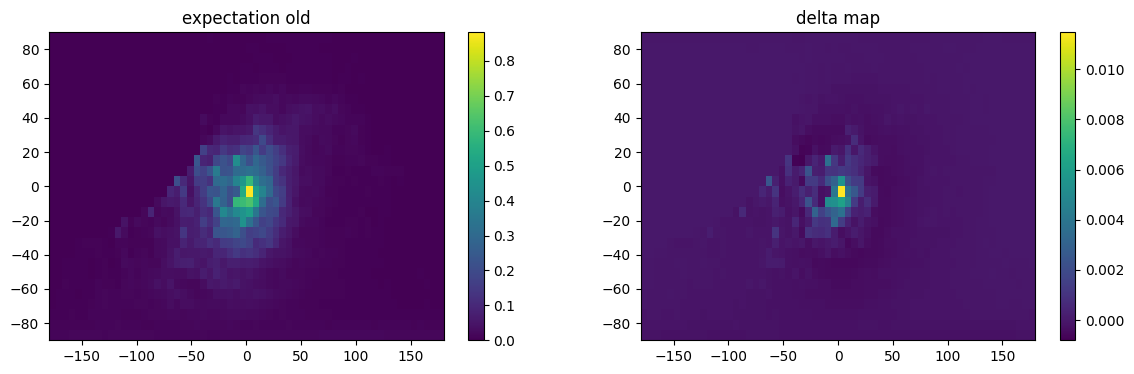

Convolving Delta image, iteration 94


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 94
Maximum acceleration parameter found:  9.489
Fitting delta-map in addition to old map, iteration 94
Proceeding without acceleration parameter.
Calculating Delta image, iteration 95, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

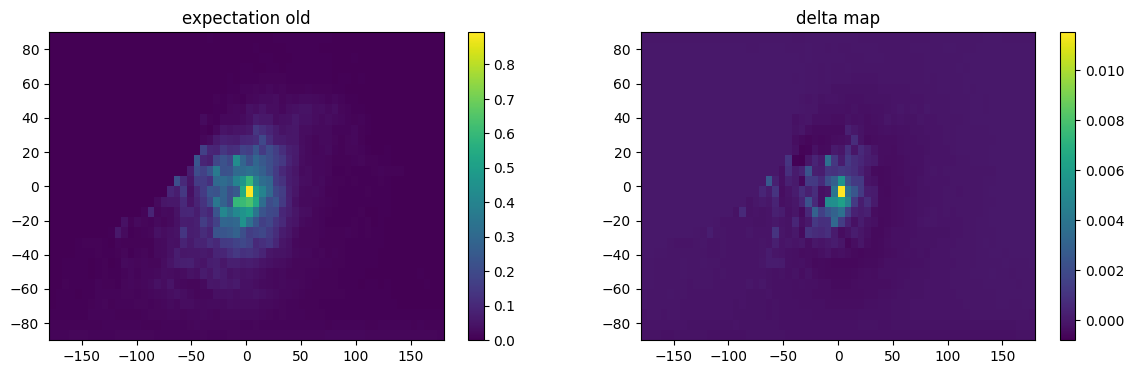

Convolving Delta image, iteration 95


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 95
Maximum acceleration parameter found:  9.501
Fitting delta-map in addition to old map, iteration 95
Proceeding without acceleration parameter.
Calculating Delta image, iteration 96, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

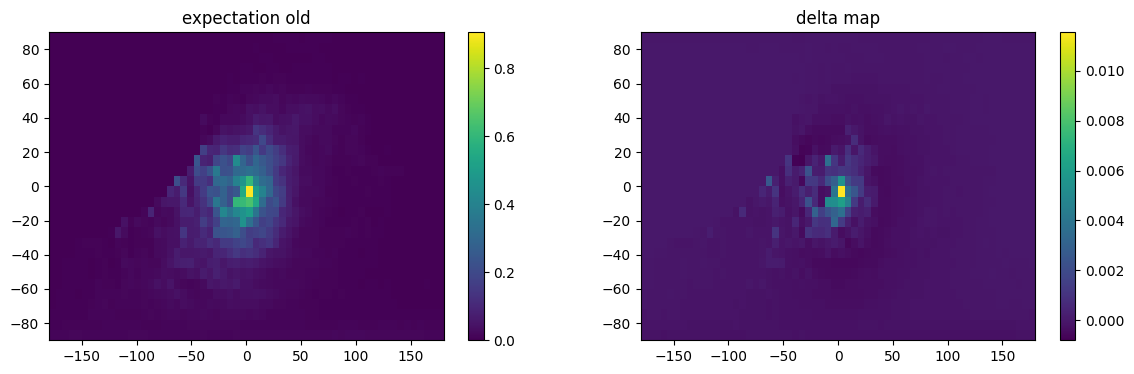

Convolving Delta image, iteration 96


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 96
Maximum acceleration parameter found:  9.512
Fitting delta-map in addition to old map, iteration 96
Proceeding without acceleration parameter.
Calculating Delta image, iteration 97, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

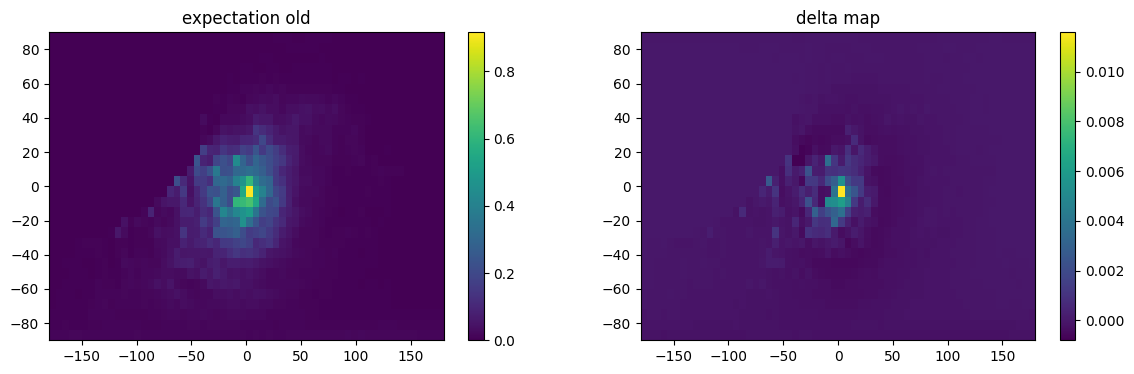

Convolving Delta image, iteration 97


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 97
Maximum acceleration parameter found:  9.524
Fitting delta-map in addition to old map, iteration 97
Proceeding without acceleration parameter.
Calculating Delta image, iteration 98, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

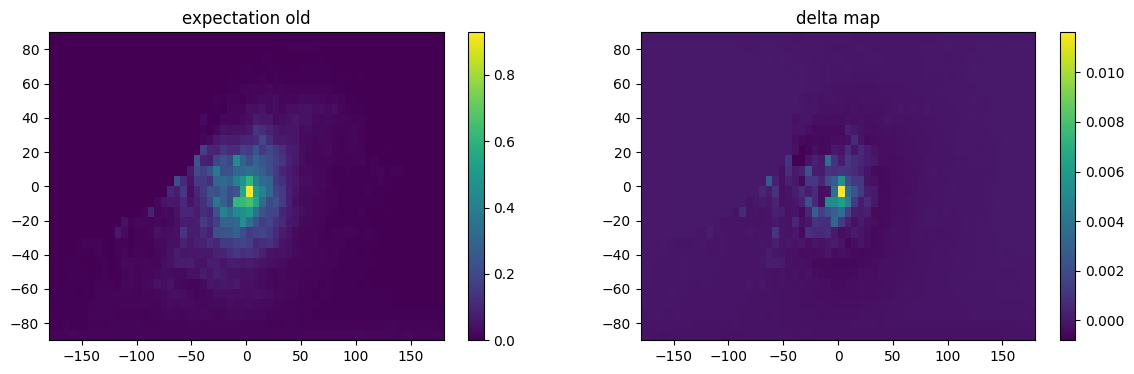

Convolving Delta image, iteration 98


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 98
Maximum acceleration parameter found:  9.535
Fitting delta-map in addition to old map, iteration 98
Proceeding without acceleration parameter.
Calculating Delta image, iteration 99, numerator


  0%|          | 0/308 [00:00<?, ?it/s]

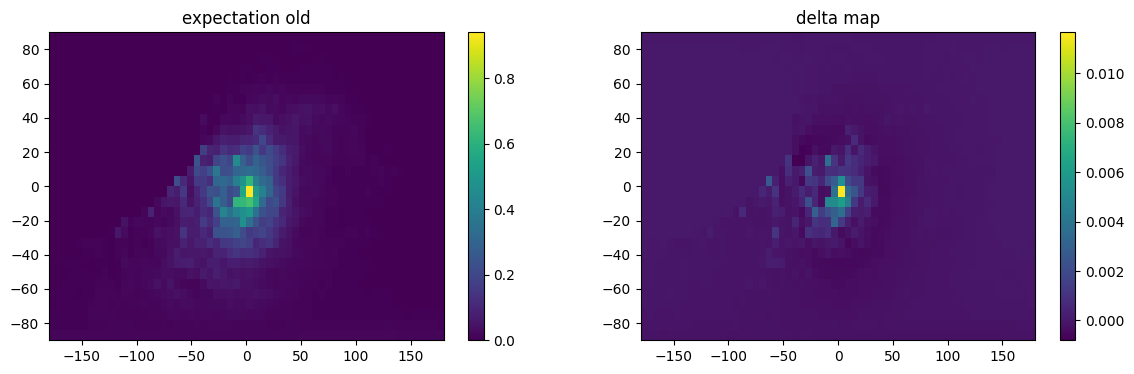

Convolving Delta image, iteration 99


  0%|          | 0/30 [00:00<?, ?it/s]

Finding maximum acceleration parameter, iteration 99
Maximum acceleration parameter found:  9.546
Fitting delta-map in addition to old map, iteration 99
Proceeding without acceleration parameter.


In [284]:
# Initial map (isotropic flat, small value)
map_init = IsoMap(L_ARR,B_ARR,1)

# Define background 
bg_cuts, idx_arr, Ncuts = background.bg_cuts, background.idx_arr, background.Ncuts

# Number of RL iterations (100 iterations is recommended)
iterations = 100

# Scalling factor for the 'Delta map', values of either 1000 or 2000 are recommended
afl_scl = 1000.

# Below are several initialise arrays to save images and other parameters to maps per iteration
map_iterations = np.zeros((n_b,n_l,iterations))
# Likelihood of maps (vs. intitial map which is fully background)
map_likelihoods = np.zeros(iterations)
# Fit likelihoods
intermediate_lp = np.zeros(iterations)
# Acceleration parameters
acc_par = np.zeros(iterations)
# Background parameters
bg_pars = np.zeros((iterations,Ncuts))

# As the zeroth iteration, copy initial map to become the 'old map' (see below)
map_old = map_init
# cf. Knoedlseder+1997 what the values denominator etc are
denominator = expo_map_crab

# The zeroth iteration is the initial map
map_iterations[:,:,0] = map_old

# Convolve this map with the response
expectation_init = 0
print('Convolving with response (init expectation), iteration 0')
for i in tqdm(range(n_b)):
    for j in range(n_l):
        expectation_init += sky_response_scaled[:,i,j,:]*map_init[i,j]

# Set the old expectation (in data space bins) to new expectation (convolved image)
expectation_old = expectation_init

# Run the modified RL algorithm for the number of iterations defined above
for its in tqdm(range(1,iterations)):
    
    # Setting the map to zero where we selected a bad exposure 
    map_old[bad_expo[0],bad_expo[1]] = 0
    # Check for each pixel to be finite
    map_old[np.where(np.isnan(map_old) == True)] = 0
    
    # Make new background for the next iteration
    bg_cuts, idx_arr, Ncuts = background.bg_cuts, background.idx_arr, background.Ncuts
    
    # Temporary background model
    tmp_model_bg = np.zeros((sky_response_scaled_time,background.bg_model_reduced[ebin].shape[1]))
    
    # Set the guess to the first background fit to 1 and set later fits to the random value of fitted_bg
    if its == 1:
        for g in range(sky_response_scaled_time):
            tmp_model_bg[g,:] = background_model[g,:]*fitted_bg_it1[idx_arr-1][g]
    else:
        for g in range(sky_response_scaled_time):
            tmp_model_bg[g,:] = background_model[g,:]*fitted_bg[idx_arr-1][g]


            
    # Expectation (in data space) is the image (expectation_old) plus the background (tmp_model_bg)
    expectation_tot_old = expectation_old + tmp_model_bg 

    # Calculate likelihood of currect total expectation
    map_likelihoods[its-1] = cashstat(crab_dataset.ravel(),expectation_tot_old.ravel())
    
    # Calculate numerator of RL algorithm
    numerator = 0
    print('Calculating Delta image, iteration '+str(its)+', numerator')
    for i in tqdm(range(sky_response_scaled_time)):
        for j in range(crab_dataset.shape[1]):
            numerator += (crab_dataset[i,j]/expectation_tot_old[i,j]-1)*sky_response_scaled[i,:,:,j]
    
    # Calculate delta map (denominator scaled by fourth root to avoid exposure edge effects)
    delta_map_tot_old = (numerator/denominator)*map_old*(denominator)**0.25
    
    # Check again for finite values and zero our bad exposure regions
    nan_idx = np.where(np.isnan(delta_map_tot_old) == 1)
    delta_map_tot_old[nan_idx[0],nan_idx[1]] = 0
    delta_map_tot_old[bad_expo[0],bad_expo[1]] = 0

    # These plots are not required but allow us to see how the RL algorithm is doing
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.pcolormesh(L_ARRg,B_ARRg,np.roll(map_old,axis=1,shift=30))
    plt.colorbar()
    plt.title('expectation old')
    plt.subplot(122)
    plt.pcolormesh(L_ARRg,B_ARRg,np.roll(delta_map_tot_old,axis=1,shift=30))
    plt.title('delta map')
    plt.colorbar()
    plt.show()
    
    # Convolve delta image
    print('Convolving Delta image, iteration '+str(its))
    conv_delta_map_tot = 0
    for i in tqdm(range(n_b)):
        for j in range(n_l):
            conv_delta_map_tot += sky_response_scaled[:,i,j,:]*delta_map_tot_old[i,j]
    
    # Find the maximum acceleration parameter to multiply with delta image
    # This will result in total image being positive everywhere
    print('Finding maximum acceleration parameter, iteration '+str(its))
    try:
        len_arr = []
        for i in range(0,10000):
            len_arr.append(len(np.where((map_old+delta_map_tot_old*i/afl_scl) < 0)[0]))
        len_arr = np.array(len_arr)
        afl = np.max(np.where(len_arr == 0)[0])
        print('Maximum acceleration parameter found: ',afl/afl_scl)

        
        # Fit delta map and current map to speed up RL algorithm
        print('Fitting delta-map in addition to old map, iteration '+str(its))
        # Dictionary for data set and prior
        data_multimap = dict(N = nonzero_idx_num,
                     Nh = sky_response_scaled_time,
                     Ncuts = Ncuts,
                     Nsky = 2,
                     acceleration_factor_limit=afl*0.95,
                     bg_cuts = bg_cuts,
                     bg_idx_arr = idx_arr,
                     y = crab_dataset.ravel().astype(int),
                     bg_model = tmp_model_bg,
                     conv_sky = np.concatenate([[expectation_old],[conv_delta_map_tot/afl_scl]]),
                     mu_flux = np.array([1,afl/2]),
                     sigma_flux = np.array([1e-2,afl]),
                     mu_Abg = fitted_bg,
                     sigma_Abg = np.repeat(0.1,Ncuts))

        # Fit;
        # Initial values for fit
        init = {}
        init['flux'] = np.array([1.,afl/2.])
        init['Abg'] = np.repeat(0.99,Ncuts)
        op2D = model_multimap.optimizing(data=data_multimap,init=init,as_vector=False,verbose=True,
                                                tol_rel_grad=1e3,tol_obj=1e-20)

        # Save values
        print('Saving new map, and fitted parameters, iteration '+str(its))
        intermediate_lp[its-1] = op2D['value']
        acc_par[its-1] = op2D['par']['flux'][1]
        bg_pars[its-1,:] = op2D['par']['Abg']
  
        # Make new map as old map plus scaled delta map
        map_new = map_old+op2D['par']['flux'][1]*delta_map_tot_old/afl_scl
    
        # Do the same with the expectation (data space)
        expectation_new = expectation_old + op2D['par']['flux'][1]*conv_delta_map_tot/afl_scl
        
    except:
        # If the fit failed...
        print('Proceeding without acceleration parameter.')
        map_new = map_old+delta_map_tot_old
        expectation_new = expectation_old + conv_delta_map_tot
    
    # Check finite values again
    if its == 1:
        bad_index_init = np.where(np.isnan(map_new) == True)
    
    # Also check that these values are zero
    map_new[bad_expo[0],bad_expo[1]] = 0
    map_new[np.where(np.isnan(map_new) == True)] = 0
    map_iterations[:,:,its] = map_new

    # Swap maps
    map_old = map_new
    
    # Also swap expectations
    expectation_old = expectation_new
    
    
    # Repeat for each iteration


<h3>Now we can extract/plot some results:</h3>

In [285]:
# Calculate the significance of the last iteration
siglist = np.abs(map_likelihoods-map_likelihoods.max())
significance = math.sqrt(siglist[-2])
print("The significance (sigma) of this image is, ", significance)

The significance (sigma) of this image is,  25.443363833941323


<h3>Calculating the fluxes of the <em>total</em> maps<br>
    If flux at position is to be calculated, select central pixel and the neighbouring pixels around that.</h3>

In [321]:
map_fluxesA = np.zeros(iterations)
for i in range(iterations):
    map_fluxesA[i] = np.sum(map_iterations[:,:,i]*domega)
print('Crab flux in ph/keV for this energy bin: ', map_fluxesA[iterations-1])

Crab flux in ph/keV for this energy bin:  0.48691305524791567


In [332]:
map_fluxesB = np.zeros(iterations)
for i in range(iterations):
    #map_iterations_nan[:,:,iterations-1]/domega/analysis.dataset.times.total_time*(DeltaE)
    map_fluxesB[i] = np.sum(map_iterations[:,:,i-1]/analysis.dataset.times.total_time*(DeltaE))
print('Crab flux in ph/cm^2/s for this energy bin: ', map_fluxesB[iterations-1])

Crab flux in ph/cm^2/s for this energy bin:  0.014409229609538348


<h3>Plotting the likelihood ratio test of all the iterations:</h3>

Text(0, 0.5, 'Test Statistic')

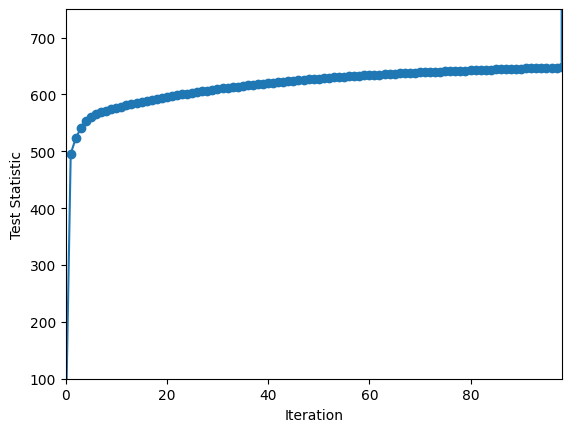

In [333]:
plt.plot(np.abs(map_likelihoods-map_likelihoods.max()),'o-')
plt.xlim(0,iterations-2 )
plt.ylim(100,750)
plt.xlabel('Iteration')
plt.ylabel('Test Statistic')

<h3> Plotting the flux of the image per iteration</h3>

Text(0, 0.5, 'Flux [ph/keV]')

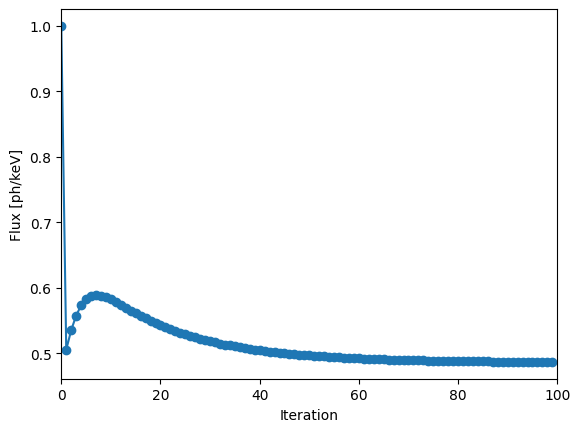

In [334]:
plt.plot(map_fluxesA,'o-')
plt.xlim(0,iterations)
plt.xlabel('Iteration')
plt.ylabel('Flux [ph/keV]')

<h3>Plot a map in galactic coordinates:</h3>

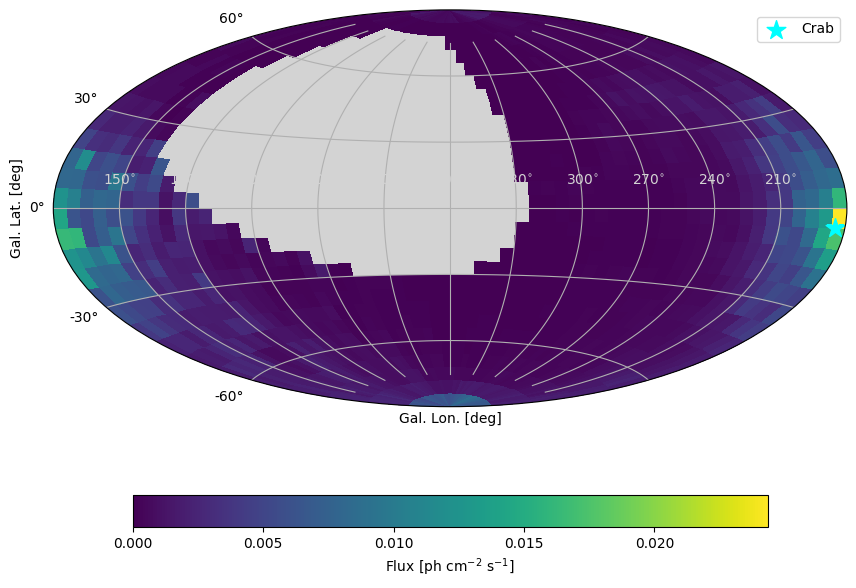

In [335]:
map_iterations_nan = np.copy(map_iterations)

plt.figure(figsize=(10.24,7.68))

# bad exposure regions will be gray
cmap = plt.get_cmap('viridis')
cmap.set_bad('lightgray')
map_iterations_nan = np.copy(map_iterations)
bad_expo = np.where(expo_map_crab/domega < 100)
for i in range(iterations):
    map_iterations_nan[bad_expo[0],bad_expo[1],i] = np.nan

plt.subplot(projection='aitoff')
plt.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,
               np.flip(map_iterations_nan[:,:,iterations-1]/domega,axis=1)/analysis.dataset.times.total_time*(DeltaE),
               cmap=cmap,
               norm=colors.PowerNorm(1),
               rasterized=True)
                
plt.xticks(np.array([-150,-120,-90,-60,-30,0,30,60,90,120,150])*deg2rad,labels=[r'$150^{\circ}$'+'\n',
                                                         r'$120^{\circ}$'+'\n',
                                                         r'$90^{\circ}$'+'\n',
                                                         r'$60^{\circ}$'+'\n',
                                                         r'$30^{\circ}$'+'\n',                       
                                                         r'$0^{\circ}$'+'\n',
                                                         r'$330^{\circ}$'+'\n',
                                                         r'$300^{\circ}$'+'\n',                       
                                                         r'$270^{\circ}$'+'\n',
                                                         r'$240^{\circ}$'+'\n',                                                    
                                                         r'$210^{\circ}$'+'\n'],color='lightgray')

plt.yticks(np.array([-60,-30,0,30,60])*deg2rad)

plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid()
cbar = plt.colorbar(orientation='horizontal', shrink=0.8)
cbar.set_label('Flux [ph cm$^{-2}$ s$^{-1}$]')

plt.scatter(np.deg2rad(360-l1),np.deg2rad(b1),color='aqua',marker='*',s=200, label= 'Crab')

plt.legend()



<h3>Creating a video of the Richardson-Lucy deconvolution:</h3>

In [336]:
# Convolve the map
map_crab = map_iterations_nan[:,:,iterations-1]
conv_map = 0
for i in tqdm(range(n_b)):
    for j in range(n_l):
        if np.isfinite(map_crab[i,j]) == True:
            conv_map += sky_response_scaled[:,i,j,:]*map_crab[i,j]
            

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1024x768 -pix_fmt rgba -r 10.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y Crab_video.mp4


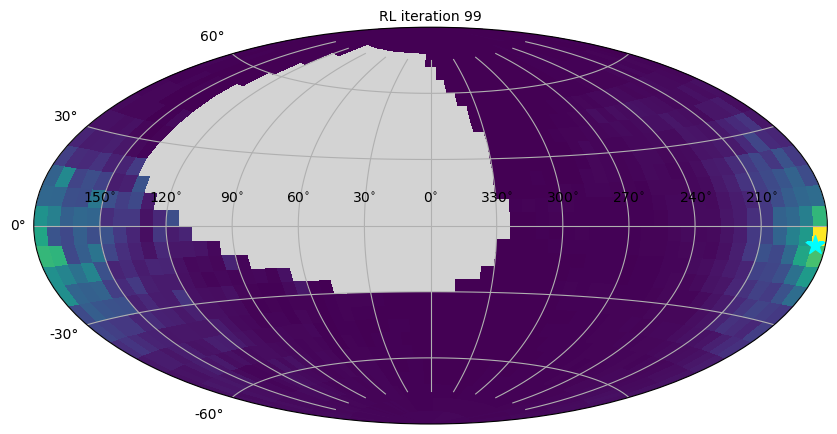

In [337]:
# Plotting for a video and saving it as an mp4 file

fig, ax = plt.subplots(figsize=(10.24,7.68),subplot_kw={'projection':'aitoff'},nrows=1,ncols=1)

ax.set_xticks(np.array([-150,-120,-90,-60,-30,0,30,60,90,120,150])*deg2rad)
ax.tick_params(axis='x', colors='black')
ax.set_xticklabels([r'$150^{\circ}$'+'\n',
                                                         r'$120^{\circ}$'+'\n',
                                                         r'$90^{\circ}$'+'\n',
                                                         r'$60^{\circ}$'+'\n',
                                                         r'$30^{\circ}$'+'\n',                       
                                                         r'$0^{\circ}$'+'\n',
                                                         r'$330^{\circ}$'+'\n',
                                                         r'$300^{\circ}$'+'\n',                       
                                                         r'$270^{\circ}$'+'\n',
                                                         r'$240^{\circ}$'+'\n',                                                    
                                                         r'$210^{\circ}$'+'\n'])
ax.set_yticks(np.array([-60,-30,0,30,60])*deg2rad)
ax.tick_params(axis='y', colors='black')


ims = []
for i in tqdm(range(iterations)):
    ttl = plt.text(0.5, 1.01, r'RL iteration {0:1.0f}'.format(i), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    img = ax.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,
                        np.flip(map_iterations_nan[:,:,i],axis=1),
                        cmap=cmap)
    ims.append([img,
                ax.scatter(np.deg2rad(360-l1),np.deg2rad(b1),color='aqua',marker='*',s=200, label= 'Crab'),
                ttl])

ax.grid()
ani = animation.ArtistAnimation(fig, ims, interval=iterations, blit=True,repeat_delay=0)
ani.save('Crab_video.mp4')

In [338]:
# Play the video!
Video('Crab_video.mp4')

<h2>You've reached the end of the notebook</h2>
If you have any questions/feedback, please email:jroberts@physics.ucsd.edu

![image of COSI SMEX poster here](COSI-SMEX_slide.png)